In [4]:
# If needed (first run):
# !pip install xarray netCDF4 h5py numpy pandas

import os, math, json
import numpy as np
import pandas as pd
import h5py, xarray as xr
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F


In [5]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA build:", torch.version.cuda)
    print("Device count:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(i, torch.cuda.get_device_name(i))


CUDA available: True
CUDA build: 12.1
Device count: 2
0 NVIDIA A40
1 NVIDIA A40


In [27]:
from pathlib import Path

# === CHANGE THIS if your base differs ===
BASE = Path("/mnt/data/data_bologna_swin_test")

# --- W3RA & stitched files ---
W3RA_DIR = BASE / "w3ra"
W3RA_MAIN = W3RA_DIR / "W3RA_2010_2024.nc"
W3RA_MAIN_ALT = W3RA_DIR / "W3RA_2010_2024_.nc"   # note trailing underscore in filename

# Individual layer files (optional; you already have them)
W3RA_FILES = {
    "S0":   W3RA_DIR / "S0_EU.nc",  
    "Sd":   W3RA_DIR / "Sd_EU.nc",
    "Sg":   W3RA_DIR / "Sg_EU.nc",
    "Sr":   W3RA_DIR / "Sr_EU.nc",
    "Ss":   W3RA_DIR / "Ss_EU.nc",
    "Ssnow":W3RA_DIR / "Ssnow_EU.nc",
    "Stot": W3RA_DIR / "Stot_EU.nc",
}

# --- InSAR choices (MintPy outputs) ---
INSAR_RAW              = BASE / "timeseries.h5"
INSAR_RES              = BASE / "timeseriesResidual.h5"
INSAR_RES_RAMP         = BASE / "timeseriesResidual_ramp.h5"
INSAR_ERA5             = BASE / "timeseries_ERA5.h5"
INSAR_ERA5_RAMP        = BASE / "timeseries_ERA5_ramp.h5"
INSAR_ERA5_RAMP_DEMERR = BASE / "timeseries_ERA5_ramp_demErr.h5"   # <-- recommended

# --- Other MintPy products ---
COH_TEMP   = BASE / "temporalCoherence.h5"
COH_SPAT   = BASE / "avgSpatialCoh.h5"
VEL_RAW    = BASE / "velocity.h5"
VEL_ERA5   = BASE / "velocityERA5.h5"

# --- Geometry & ifgram stack (for incidence/az/LOS→vertical etc.) ---
GEOM_H5    = BASE / "inputs" / "geometryGeo.h5"
IFGRAM_H5  = BASE / "inputs" / "ifgramStack.h5"



In [7]:
import xarray as xr
import numpy as np

def inspect_w3ra_nc(path: Path):
    print("\n---", path.name, "---")
    if not path.exists():
        print("  (missing)")
        return
    ds = xr.open_dataset(path)
    try:
        #print("  dims:", {k:int(v) for k,v in ds.dims.items()})
        print("  dims:", dict(ds.sizes)) # more concise
        print("  data vars (first 15):", list(ds.data_vars)[:15])
        # Try to show time coordinates if present under common names
        if "time" in ds:
            t = ds["time"].values
            print(f"  time len={len(t)}  first={t[:3]}  last={t[-3:]}")
        else:
            # Some stitched files have per-year dims (e.g., time_2010, time_2011, ...)
            year_dims = [k for k in ds.dims if k.startswith("time_")]
            if year_dims:
                print("  multi-year time dims:", year_dims[:10], "...")
                for k in year_dims[:3]:
                    v = ds[k].values
                    print(f"   {k}: len={len(v)} first={v[:2]} last={v[-2:]}")
    finally:
        ds.close()


In [8]:

inspect_w3ra_nc(W3RA_MAIN)
inspect_w3ra_nc(W3RA_MAIN_ALT)



--- W3RA_2010_2024.nc ---
  dims: {'lat': 22, 'lon': 24}
  data vars (first 15): []

--- W3RA_2010_2024_.nc ---


  dims: {'lat': 22, 'lon': 24, 'time_2010': 365, 'time_2011': 365, 'time_2012': 366, 'time_2013': 365, 'time_2014': 365, 'time_2015': 365, 'time_2016': 366, 'time_2017': 365, 'time_2018': 365, 'time_2019': 365, 'time_2020': 366, 'time_2021': 365, 'time_2022': 365, 'time_2023': 365, 'time_2024': 213}
  data vars (first 15): ['S0_EU_2010', 'Sd_EU_2010', 'Sg_EU_2010', 'Sr_EU_2010', 'Ss_EU_2010', 'Ssnow_EU_2010', 'Stot_EU_2010', 'S0_EU_2011', 'Sd_EU_2011', 'Sg_EU_2011', 'Sr_EU_2011', 'Ss_EU_2011', 'Ssnow_EU_2011', 'Stot_EU_2011', 'S0_EU_2012']
  multi-year time dims: ['time_2010', 'time_2011', 'time_2012', 'time_2013', 'time_2014', 'time_2015', 'time_2016', 'time_2017', 'time_2018', 'time_2019'] ...
   time_2010: len=365 first=['2010-01-02T00:00:00.000000000' '2010-01-03T00:00:00.000000000'] last=['2010-12-31T00:00:00.000000000' '2011-01-01T00:00:00.000000000']
   time_2011: len=365 first=['2011-01-02T00:00:00.000000000' '2011-01-03T00:00:00.000000000'] last=['2011-12-31T00:00:00.000000000

In [11]:
import h5py

def walk_h5(fn: Path, max_attr=10):
    print("\nHDF5 file:", fn)
    if not fn.exists():
        print("  (missing)")
        return
    with h5py.File(fn, "r") as f:
        def _show(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"  [DATASET] {name:35s} shape={obj.shape} dtype={obj.dtype}")
                # show a few attributes commonly used by MintPy
                if obj.attrs:
                    keys = list(obj.attrs.keys())[:max_attr]
                    kv = {k: obj.attrs[k] for k in keys}
                    print("           attrs:", kv)
            elif isinstance(obj, h5py.Group):
                print(f"  [GROUP]   {name}")
        f.visititems(_show)


In [12]:

# Inspect whichever timeseries you plan to use:
walk_h5(INSAR_ERA5_RAMP_DEMERR)   # recommended one
# Optionally look at others:
walk_h5(INSAR_ERA5)
walk_h5(INSAR_RAW)
walk_h5(INSAR_RES_RAMP)

# Coherence & velocities:
walk_h5(COH_TEMP)
walk_h5(COH_SPAT)
walk_h5(VEL_RAW)
walk_h5(VEL_ERA5)

# Geometry & ifgram (for LOS->vertical, footprint, etc.)
walk_h5(GEOM_H5)
walk_h5(IFGRAM_H5)



HDF5 file: /mnt/data/data_bologna_swin_test/timeseries_ERA5_ramp_demErr.h5
  [DATASET] bperp                               shape=(156,) dtype=float32
  [DATASET] date                                shape=(156,) dtype=|S8
  [DATASET] timeseries                          shape=(156, 2939, 3713) dtype=float32

HDF5 file: /mnt/data/data_bologna_swin_test/timeseries_ERA5.h5
  [DATASET] bperp                               shape=(156,) dtype=float32
  [DATASET] date                                shape=(156,) dtype=|S8
  [DATASET] timeseries                          shape=(156, 2939, 3713) dtype=float32

HDF5 file: /mnt/data/data_bologna_swin_test/timeseries.h5
  [DATASET] bperp                               shape=(156,) dtype=float32
  [DATASET] date                                shape=(156,) dtype=|S8
  [DATASET] timeseries                          shape=(156, 2939, 3713) dtype=float32

HDF5 file: /mnt/data/data_bologna_swin_test/timeseriesResidual_ramp.h5
  [DATASET] bperp                

In [13]:
import h5py, numpy as np

def summarize_h5(path):
    with h5py.File(path, "r") as f:
        print(f"\n {path}")
        print("Keys:", list(f.keys()))
        for k, obj in f.items():
            if isinstance(obj, h5py.Dataset):
                print(f"  ▶ {k:18s} shape={obj.shape} dtype={obj.dtype}")
                if obj.attrs:
                    print("     attrs:", list(obj.attrs.keys())[:6])
            else:
                print(f"  {k}")
        # MintPy-specific fields
        if "date" in f:
            raw = f["date"][:]
            dates = [d.decode() if isinstance(d, (bytes, np.bytes_)) else str(d) for d in raw]
            print(f" {len(dates)} dates | first: {dates[:3]} | last: {dates[-3:]}")
        if "timeseries" in f:
            print(f" timeseries shape: {f['timeseries'].shape}")


In [14]:
# Inspect whichever timeseries you plan to use:
summarize_h5(INSAR_ERA5_RAMP_DEMERR)   # recommended one
# Optionally look at others:
summarize_h5(INSAR_ERA5)
summarize_h5(INSAR_RAW)
summarize_h5(INSAR_RES_RAMP)

# Coherence & velocities:
summarize_h5(COH_TEMP)
summarize_h5(COH_SPAT)
summarize_h5(VEL_RAW)
summarize_h5(VEL_ERA5)

# Geometry & ifgram (for LOS->vertical, footprint, etc.)
summarize_h5(GEOM_H5)
summarize_h5(IFGRAM_H5)





 /mnt/data/data_bologna_swin_test/timeseries_ERA5_ramp_demErr.h5
Keys: ['bperp', 'date', 'timeseries']
  ▶ bperp              shape=(156,) dtype=float32
  ▶ date               shape=(156,) dtype=|S8
  ▶ timeseries         shape=(156, 2939, 3713) dtype=float32
 156 dates | first: ['20170610', '20170622', '20170704'] | last: ['20220912', '20221006', '20221018']
 timeseries shape: (156, 2939, 3713)

 /mnt/data/data_bologna_swin_test/timeseries_ERA5.h5
Keys: ['bperp', 'date', 'timeseries']
  ▶ bperp              shape=(156,) dtype=float32
  ▶ date               shape=(156,) dtype=|S8
  ▶ timeseries         shape=(156, 2939, 3713) dtype=float32
 156 dates | first: ['20170610', '20170622', '20170704'] | last: ['20220912', '20221006', '20221018']
 timeseries shape: (156, 2939, 3713)

 /mnt/data/data_bologna_swin_test/timeseries.h5
Keys: ['bperp', 'date', 'timeseries']
  ▶ bperp              shape=(156,) dtype=float32
  ▶ date               shape=(156,) dtype=|S8
  ▶ timeseries         shape=

In [15]:
def load_insar_h5_as_xarray(path: Path) -> xr.DataArray:
    with h5py.File(path, "r") as f:
        # dates
        if "date" not in f:
            raise ValueError("No 'date' dataset found in HDF5.")
        raw = f["date"][:]
        dates = [d.decode() if isinstance(d, (bytes, np.bytes_)) else str(d) for d in raw]
        # MintPy often uses YYYYMMDD
        time = pd.to_datetime(dates, format="%Y%m%d", errors="coerce")
        # data
        ts = f["timeseries"][:]  # either (T,H,W) or (H,W,T)
        if ts.ndim != 3:
            raise ValueError("Expected 3D timeseries.")
        # infer axis order
        T, H, W = None, None, None
        if ts.shape[0] == len(time):        # (T,H,W)
            T, H, W = ts.shape
            data = ts
        elif ts.shape[-1] == len(time):     # (H,W,T)
            H, W, T = ts.shape
            data = np.transpose(ts, (2,0,1))   # -> (T,H,W)
        else:
            raise ValueError("Could not infer time axis. Check shapes/dates.")

        # build y/x coords (try attributes, else pixel indices)
        H5_attrs = f["timeseries"].attrs
        def get_attr(name, default=None):
            return H5_attrs[name] if name in H5_attrs else default

        # MintPy geocoded often has: X_FIRST, Y_FIRST, X_STEP, Y_STEP (lon/lat grid)
        x_first = get_attr("X_FIRST", None)
        y_first = get_attr("Y_FIRST", None)
        x_step  = get_attr("X_STEP", None)
        y_step  = get_attr("Y_STEP", None)
        if None not in (x_first, y_first, x_step, y_step):
            x = x_first + np.arange(W) * x_step
            y = y_first + np.arange(H) * y_step
        else:
            # fallback pixel indices
            x = np.arange(W)
            y = np.arange(H)

    da = xr.DataArray(
        data,
        dims=("time","y","x"),
        coords={"time": time, "y": y, "x": x},
        name="insar_deformation"
    )
    return da


In [16]:
# 1) Build "insar_m" (monthly, subset, with lat/lon)
#    If already executed existing cells to create insar_m, SKIP to step 2.
#    Otherwise uncomment the next block to get a compact version:

import h5py, pandas as pd
def load_insar_h5_as_xarray(path: Path) -> xr.DataArray:
    with h5py.File(path, "r") as f:
        dates = [d.decode() for d in f["date"][:]]
        time = pd.to_datetime(dates, format="%Y%m%d", errors="coerce")
        ts = f["timeseries"][:]
        T, H, W = ts.shape if ts.shape[0]==len(time) else np.transpose(ts,(2,0,1)).shape
        da = xr.DataArray(ts if ts.shape[0]==len(time) else np.transpose(ts,(2,0,1)),
                          dims=("time","y","x"), coords={"time": time}, name="insar_deformation")
    return da



In [17]:
insar_da = load_insar_h5_as_xarray(INSAR_ERA5_RAMP_DEMERR)
# attach lat/lon using your existing geometry logic (you already have a working cell for this)
# resample monthly & subset to the InSAR time window
insar_m = insar_da.resample(time="MS").mean().sel(time=slice("2017-06-01","2022-10-31"))


In [18]:

insar_da


<xarray.DataArray 'insar_deformation' (time: 156, y: 2939, x: 3713)> Size: 7GB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]],
      shape=(156, 2939, 3713), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2017-06-10 2017-06-22 ... 2022-10-18
Dimensions without coordinates: y, x

In [19]:
insar_m


<xarray.DataArray 'insar_deformation' (time: 65, y: 2939, x: 3713)> Size: 3GB
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],
      shape=(65, 2939, 3713), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 520B 2017-06-01 2017-07-01 ... 2022-10-01
Dimensions without coordinates: y, x

In [20]:
import numpy as np, pandas as pd, xarray as xr, h5py
from pyproj import Transformer

# InSAR → xarray (time,y,x). We’ll add lat/lon 
with h5py.File(INSAR_ERA5_RAMP_DEMERR, "r") as f:
    ts   = f["timeseries"][:]                                # (T,H,W) or (H,W,T) in some files
    if ts.ndim == 3 and ts.shape[0] != f["date"].shape[0]:
        # MintPy variant (H,W,T) → (T,H,W)
        ts = np.transpose(ts, (2,0,1))
    dates = [d.decode() for d in f["date"][:]]
    time  = pd.to_datetime(dates, format="%Y%m%d", errors="coerce")

insar_da = xr.DataArray(
    ts, dims=("time","y","x"),
    coords={"time": time, "y": np.arange(ts.shape[1]), "x": np.arange(ts.shape[2])},
    name="insar_deformation"
)

# Build lat/lon from geometry
with h5py.File(GEOM_H5, "r") as g:
    EPSG    = int(g.attrs.get("EPSG", 32633))  # fallback UTM 33N if absent
    X_FIRST = float(g.attrs["X_FIRST"]);  X_STEP = float(g.attrs["X_STEP"])
    Y_FIRST = float(g.attrs["Y_FIRST"]);  Y_STEP = float(g.attrs["Y_STEP"])

H, W = insar_da.sizes["y"], insar_da.sizes["x"]
x_e = X_FIRST + np.arange(W) * X_STEP
y_n = Y_FIRST + np.arange(H) * Y_STEP
XX, YY = np.meshgrid(x_e, y_n)                   # (H,W) easting/northing

to_ll = Transformer.from_crs(EPSG, 4326, always_xy=True)
lon2d, lat2d = to_ll.transform(XX, YY)

insar_da = insar_da.assign_coords(lat=(("y","x"), lat2d.astype("float32")),
                                  lon=(("y","x"), lon2d.astype("float32")))

# Monthly mean + subset to the InSAR span you used earlier
tmin_insar = pd.Timestamp("2017-06-01")
tmax_insar = pd.Timestamp("2022-10-31")
insar_m = insar_da.resample(time="MS").mean().sel(time=slice(tmin_insar, tmax_insar))

print("InSAR monthly:", insar_m.shape, "| coords:", [c for c in insar_m.coords if c in ("lat","lon")])


InSAR monthly: (65, 2939, 3713) | coords: ['lat', 'lon']


In [21]:
# After build insar_m (monthly mean + time slice)
print("insar_m dims:", insar_m.dims)
print("insar_m coords:", list(insar_m.coords))
for c in ("lat","lon"):
    v = insar_m.coords.get(c, None)
    print(c, "->", None if v is None else (v.dims, v.shape, str(v.dtype)))


insar_m dims: ('time', 'y', 'x')
insar_m coords: ['y', 'x', 'time', 'lat', 'lon']
lat -> (('y', 'x'), (2939, 3713), 'float32')
lon -> (('y', 'x'), (2939, 3713), 'float32')


In [22]:
import xarray as xr
import pandas as pd
import re
from pathlib import Path



def stitch_years(ds, base_prefix):
    """
    Collect variables like f'{base_prefix}_{YYYY}' each with dim 'time_YYYY',
    rename that dim to 'time', cast to datetime, then concat over time.
    Returns a single DataArray with dims (time, lat, lon).
    """
    pats = []
    for k in ds.data_vars:
        m = re.fullmatch(fr"{re.escape(base_prefix)}_(\d{{4}})", k)
        if m: pats.append((int(m.group(1)), k))
    if not pats:
        raise ValueError(f"No yearly vars found for prefix {base_prefix}")
    pats.sort()  # by year
    chunks = []
    for year, var in pats:
        da = ds[var]
        time_dim = f"time_{year}"
        if time_dim not in da.dims:
            raise ValueError(f"{var} missing dim {time_dim}")
        da = da.rename({time_dim: "time"})
        # ensure datetime64
        da = da.assign_coords(time=pd.to_datetime(da['time'].values))
        chunks.append(da)
    out = xr.concat(chunks, dim="time")
    return out

In [21]:
# 2) Open W3RA and stitch per-year vars into continuous time (for each layer)
import re
def stitch_years(ds: xr.Dataset, base_prefix: str) -> xr.DataArray:
    """Collect {base_prefix}_{YYYY} (each with dim 'time_YYYY'), rename to 'time', concat."""
    pats = []
    for k in ds.data_vars:
        m = re.fullmatch(fr"{re.escape(base_prefix)}_(\d{{4}})", k)
        if m: pats.append((int(m.group(1)), k))
    if not pats:
        raise ValueError(f"No yearly vars found for prefix {base_prefix}")
    pats.sort()
    chunks = []
    for year, var in pats:
        da = ds[var]
        tdim = f"time_{year}"
        if tdim not in da.dims:
            raise ValueError(f"{var} missing dim {tdim}")
        da = da.rename({tdim: "time"})
        da = da.assign_coords(time=xr.conventions.decode_cf_datetime(da["time"]))
        chunks.append(da)
    return xr.concat(chunks, dim="time")


In [25]:

# Decide which layer prefixes to include (7 storages present in your file)
LAYER_BASES = {
    "S0":   "S0_EU",
    "Ss":   "Ss_EU",
    "Sd":   "Sd_EU",
    "Sg":   "Sg_EU",
    "Sr":   "Sr_EU",
    "Ssnow":"Ssnow_EU",
    "Stot": "Stot_EU",
}

ds_w = xr.open_dataset(W3RA_MAIN_ALT, engine="netcdf4")

# Stitch each available layer
stitched = {}
for short, base in LAYER_BASES.items():
    try:
        stitched[short] = stitch_years(ds_w, base)  # (time, lat, lon)
    except Exception as e:
        print(f"Skip {short} ({base}):", e)


In [ ]:
name_map = {"Sg":"Sg", "Sd":"Sd", "S0":"S0"}
for k in list(ds_w.data_vars):
    kl = k.lower()
    if "sg" in kl: name_map["Sg"] = k
    if "sg" in kl: name_map["Sg"] = k
    if "sg" in kl: name_map["Sg"] = k
    if "sd" in kl: name_map["Sd"] = k
    if "s0" in kl or "stot0" in kl: name_map["S0"] = k

sg_all = ds_w[name_map["Sg"]]
sd_all = ds_w[name_map["Sd"]]
s0_all = ds_w[name_map["S0"]]
print("picked:", name_map)
print(sg_all.shape, sd_all.shape, s0_all.shape, sg_all.dims)


picked: {'Sg': 'Sg_EU_2024', 'Sd': 'Sd_EU_2024', 'S0': 'S0_EU_2024'}
(213, 22, 24) (213, 22, 24) (213, 22, 24) ('time_2024', 'lat', 'lon')


In [26]:
# 3) Monthly means and subset to the InSAR monthly window
tmin, tmax = insar_m.time.values[[0, -1]]
for k in list(stitched):
    stitched[k] = stitched[k].resample(time="MS").mean().sel(time=slice(tmin, tmax))

In [32]:
# 4) Regrid W3RA (lat,lon) -> InSAR (y,x) using bilinear interp on the InSAR lat/lon grid
#     Assumes your insar_m already has 2D coords 'lat' and 'lon' (as in your earlier cell).
#     If they are 1D, xarray will broadcast automatically.

regridded = {}
for k, da in stitched.items():
    regridded[k] = da.interp(lat=insar_m["lat"], lon=insar_m["lon"], method="linear") \
                     .transpose("time","y","x") \
                     .astype("float32")

In [ ]:
# 4) Regrid W3RA (lat,lon) -> InSAR (y,x) using bilinear interp on the InSAR lat/lon grid
#     Assumes your insar_m already has 2D coords 'lat' and 'lon' (as in your earlier cell).
#     If they are 1D, xarray will broadcast automatically.

regridded = {}
for k, da in stitched.items():
    regridded[k] = da.interp(lat=insar_m["lat"], lon=insar_m["lon"], method="linear") \
                     .transpose("time","y","x") \
                     .astype("float32")


In [ ]:
# 5) Canonicalize and save NetCDFs (same filenames & structure as before)

# InSAR dataset
ds_insar = xr.Dataset({"insar_deformation": insar_m.astype("float32").transpose("time","y","x")})

# W3RA dataset with all available layers
ds_w3ra = xr.Dataset({k: v for k, v in regridded.items()})

enc_i  = {k: {"zlib": True, "complevel": 4} for k in ds_insar.data_vars}
enc_w  = {k: {"zlib": True, "complevel": 4} for k in ds_w3ra.data_vars}

out_insar = BASE / "insar_aligned_new.nc"
out_w3ra  = BASE / "w3ra_aligned_new.nc"

ds_insar.to_netcdf(out_insar, encoding=enc_i)
ds_w3ra.to_netcdf(out_w3ra,  encoding=enc_w)

print("Saved:")
print(" ", out_insar, dict(ds_insar.dims))
print(" ", out_w3ra,  dict(ds_w3ra.dims), list(ds_w3ra.data_vars))

# 3) Inspect W3RA NetCDFs and pick variable names

In [15]:
ds = xr.open_dataset(W3RA_DIR / "W3RA_2010_2024_.nc")
# Adjust names if different in your file:
name_map = {"Sg":"Sg", "Sd":"Sd", "S0":"S0"}
for k in list(ds.data_vars):
    kl = k.lower()
    if "sg" in kl: name_map["Sg"] = k
    if "sd" in kl: name_map["Sd"] = k
    if "s0" in kl or "stot0" in kl: name_map["S0"] = k

sg_all = ds[name_map["Sg"]]
sd_all = ds[name_map["Sd"]]
s0_all = ds[name_map["S0"]]
print("picked:", name_map)
print(sg_all.shape, sd_all.shape, s0_all.shape, sg_all.dims)


picked: {'Sg': 'Sg_EU_2024', 'Sd': 'Sd_EU_2024', 'S0': 'S0_EU_2024'}
(213, 22, 24) (213, 22, 24) (213, 22, 24) ('time_2024', 'lat', 'lon')


Stitch W3RA years into continuous time series

In [16]:
import xarray as xr
import pandas as pd
import re
from pathlib import Path



def stitch_years(ds, base_prefix):
    """
    Collect variables like f'{base_prefix}_{YYYY}' each with dim 'time_YYYY',
    rename that dim to 'time', cast to datetime, then concat over time.
    Returns a single DataArray with dims (time, lat, lon).
    """
    pats = []
    for k in ds.data_vars:
        m = re.fullmatch(fr"{re.escape(base_prefix)}_(\d{{4}})", k)
        if m: pats.append((int(m.group(1)), k))
    if not pats:
        raise ValueError(f"No yearly vars found for prefix {base_prefix}")
    pats.sort()  # by year
    chunks = []
    for year, var in pats:
        da = ds[var]
        time_dim = f"time_{year}"
        if time_dim not in da.dims:
            raise ValueError(f"{var} missing dim {time_dim}")
        da = da.rename({time_dim: "time"})
        # ensure datetime64
        da = da.assign_coords(time=pd.to_datetime(da['time'].values))
        chunks.append(da)
    out = xr.concat(chunks, dim="time")
    return out


In [17]:

sg_all = stitch_years(ds, "Sg_EU")
sd_all = stitch_years(ds, "Sd_EU")
s0_all = stitch_years(ds, "S0_EU")
print(sg_all.shape, sd_all.shape, s0_all.shape, sg_all.dims)


(5326, 22, 24) (5326, 22, 24) (5326, 22, 24) ('time', 'lat', 'lon')


# 4) Align the time window to your InSAR 
(2017-06-10 → 2022-10-18) and monthly resample

In [18]:
# InSAR time range from your HDF5 summary:
tmin_insar = pd.Timestamp("2017-06-01")   # round to month for resample
tmax_insar = pd.Timestamp("2022-10-31")

# Monthly means
sg_m = sg_all.resample(time="MS").mean()
sd_m = sd_all.resample(time="MS").mean()
s0_m = s0_all.resample(time="MS").mean()

# Subset to common window
sg_m = sg_m.sel(time=slice(tmin_insar, tmax_insar))
sd_m = sd_m.sel(time=slice(tmin_insar, tmax_insar))
s0_m = s0_m.sel(time=slice(tmin_insar, tmax_insar))
print("W3RA monthly shapes:", sg_m.shape, sd_m.shape, s0_m.shape)


W3RA monthly shapes: (65, 22, 24) (65, 22, 24) (65, 22, 24)


# 5) Build InSAR xarray with lat/lon from HDF5 attrs (1D grid)

In [ ]:
import h5py, numpy as np, xarray as xr, pandas as pd
from pathlib import Path


with h5py.File(INSAR_H5, "r") as f:
    ts = f["timeseries"][:]             # (T,H,W)
    raw_dates = [d.decode() for d in f["date"][:]]
    time = pd.to_datetime(raw_dates, format="%Y%m%d")
    attrs = f["timeseries"].attrs
    X_FIRST = attrs.get("X_FIRST", None)
    Y_FIRST = attrs.get("Y_FIRST", None)
    X_STEP  = attrs.get("X_STEP",  None)
    Y_STEP  = attrs.get("Y_STEP",  None)

T,H,W = ts.shape
insar_da = xr.DataArray(ts, dims=("time","y","x"),
                        coords={"time": time,
                                "y": np.arange(H),
                                "x": np.arange(W)},
                        name="insar_deformation")

# If geocoded attrs are present, add lon/lat 1D coords
if None not in (X_FIRST, X_STEP, Y_FIRST, Y_STEP):
    lon_1d = X_FIRST + np.arange(W) * X_STEP
    lat_1d = Y_FIRST + np.arange(H) * Y_STEP
    insar_da = insar_da.assign_coords(lon=("x", lon_1d), lat=("y", lat_1d))

# Resample to monthly means and subset
insar_m = insar_da.resample(time="MS").mean().sel(time=slice(tmin_insar, tmax_insar))
print("InSAR monthly shape:", insar_m.shape)


InSAR monthly shape: (65, 2939, 3713)


In [20]:
import h5py
from pathlib import Path


with h5py.File(INSAR_H5, "r") as g:
    print("Top-level datasets:", list(g.keys()))           # e.g., ['latitude','longitude',...]
    for k in ["latitude","longitude","y","x","azimuthCoord","rangeCoord"]:
        if k in g:
            print(k, g[k].shape, g[k].dtype)
    # global attrs can carry projection info (EPSG/UTM zone)
    print("attrs:", {a: g.attrs[a] for a in g.attrs.keys()})


Top-level datasets: ['bperp', 'date', 'timeseries']
attrs: {'ALOOKS': '4', 'ANTENNA_SIDE': '-1', 'AZIMUTH_PIXEL_SIZE': '56.4', 'BANDS': '1', 'CENTER_LINE_UTC': '19151.797495', 'DATA_TYPE': 'float32', 'DATE12': '170610-170622', 'EARTH_RADIUS': '6367896.9087', 'END_DATE': '20221018', 'EPSG': '32633', 'FILE_LENGTH': '2945', 'FILE_PATH': '/mnt/data/aoi_3_02_bologna/MintPy/timeseries_ERA5_ramp_demErr.h5', 'FILE_TYPE': 'timeseries', 'HEADING': '-165.9793419', 'HEIGHT': '701867.9117', 'INTERLEAVE': 'BSQ', 'LAT_REF1': '5011480.0', 'LAT_REF2': '5011480.0', 'LAT_REF3': '4775880.0', 'LAT_REF4': '4775880.0', 'LENGTH': '2939', 'LON_REF1': '413880.0', 'LON_REF2': '116360.0', 'LON_REF3': '413880.0', 'LON_REF4': '116360.0', 'NO_DATA_VALUE': '0.0', 'NoDataValue': '0.0', 'ORBIT_DIRECTION': 'DESCENDING', 'PLATFORM': 'Sen', 'PROCESSOR': 'hyp3', 'PROJECT_NAME': 'mintpy_config', 'P_BASELINE_BOTTOM_HDR': '-3.725', 'P_BASELINE_TOP_HDR': '-3.725', 'RANGE_PIXEL_SIZE': '46.0', 'REF_DATE': '20220103', 'REF_LAT': 

In [21]:
import h5py
with h5py.File(INSAR_H5, "r") as f:
    A = f["timeseries"].attrs
    print({k: A[k] for k in ["EPSG","X_FIRST","X_STEP","X_UNIT","Y_FIRST","Y_STEP","Y_UNIT"] if k in A})


{}


In [22]:
import numpy as np
import h5py
from pyproj import Transformer

# ------------- get UTM grid from geometryGeo.h5 -------------
geom_path = r"C:\Users\JR80FD\swin_test\inputs\geometryGeo.h5"
with h5py.File(geom_path, "r") as g:
    EPSG = int(g.attrs.get("EPSG", 32633))           # 32633 = UTM 33N
    X_FIRST = float(g.attrs["X_FIRST"])              # meters
    X_STEP  = float(g.attrs["X_STEP"])               # meters
    Y_FIRST = float(g.attrs["Y_FIRST"])              # meters
    Y_STEP  = float(g.attrs["Y_STEP"])               # meters

H = insar_da.sizes["y"]
W = insar_da.sizes["x"]

# Easting/Northing 1D
x_e = X_FIRST + np.arange(W) * X_STEP                # shape (W,)
y_n = Y_FIRST + np.arange(H) * Y_STEP                # shape (H,)

# 2D mesh in UTM
XX, YY = np.meshgrid(x_e, y_n)                       # (H,W)

# Transform UTM -> lon/lat
to_ll = Transformer.from_crs(EPSG, 4326, always_xy=True)
lon2d, lat2d = to_ll.transform(XX, YY)               # float64 arrays

# keep memory sane
lon2d = lon2d.astype("float32")
lat2d = lat2d.astype("float32")

# Attach as coords to your existing insar_da
insar_da = insar_da.assign_coords(lat=(("y","x"), lat2d),
                                  lon=(("y","x"), lon2d))

# Monthly resample + subset (reuse your existing time window if you defined it)
insar_m = insar_da.resample(time="MS").mean()
insar_m = insar_m.sel(time=slice("2017-06-01", "2022-10-31"))

print("InSAR monthly:", insar_m.shape, "| coords now:", [c for c in insar_m.coords if c in ("lat","lon")])


InSAR monthly: (65, 2939, 3713) | coords now: ['lat', 'lon']


In [23]:
print(INSAR_H5)

C:\Users\jr80fd\swin_test\timeseries_ERA5_ramp_demErr.h5


# 6) Interpolate W3RA → InSAR grid (bilinear)

W3RA is daily (2010–2024).

InSAR is irregular (6/12 days) but you resampled it to monthly means (156 steps for 2017–2022).
Both datasets aligned as 4D tensors

In [24]:
# Time-align first
insar_m, sg_m = xr.align(insar_m, sg_m, join="inner")
_, sd_m = xr.align(insar_m, sd_m, join="inner")
_, s0_m = xr.align(insar_m, s0_m, join="inner")

# Bilinear interpolation onto the 2D lon/lat of InSAR
sg_on_insar = sg_m.interp(lat=insar_m["lat"], lon=insar_m["lon"], method="linear")
sd_on_insar = sd_m.interp(lat=insar_m["lat"], lon=insar_m["lon"], method="linear")
s0_on_insar = s0_m.interp(lat=insar_m["lat"], lon=insar_m["lon"], method="linear")

print("Regridded:", sg_on_insar.shape, sd_on_insar.shape, s0_on_insar.shape)


Regridded: (65, 2939, 3713) (65, 2939, 3713) (65, 2939, 3713)


In [70]:
# === Step 1 (revised): build canonical NetCDFs from your regridded arrays ===
import xarray as xr
import numpy as np
from pathlib import Path

def canonicalize_da(da: xr.DataArray) -> xr.DataArray:
    """Ensure dims are (time,y,x). Keep lat/lon only as auxiliary coords."""
    # If da has lat/lon as dims, rename them
    rn = {}
    if "lat" in da.dims: rn["lat"] = "y"
    if "lon" in da.dims: rn["lon"] = "x"
    da = da.rename(rn)
    # Always transpose to (time,y,x)
    target_order = [d for d in ("time","y","x") if d in da.dims]
    da = da.transpose(*target_order)
    return da


def pick_insar_da(obj):
    """Return the deformation DataArray from either a DataArray or a Dataset."""
    if isinstance(obj, xr.DataArray):
        return obj
    elif isinstance(obj, xr.Dataset):
        # prefer common names if present
        for name in ("insar_deformation","uz","u","disp","defo","unw","vel","def"):
            if name in obj.data_vars:
                return obj[name]
        # fallback: first data var
        return obj[list(obj.data_vars)[0]]
    else:
        raise TypeError("insar_m must be an xarray DataArray or Dataset")

# 1) Get DataArrays and canonicalize dims to (time,y,x)
insar_da = canonicalize_da(pick_insar_da(insar_m))
sg_da    = canonicalize_da(sg_on_insar)
s0_da    = canonicalize_da(s0_on_insar)

try:
    _ = sd_on_insar
    has_sd = True
    sd_da = canonicalize_da(sd_on_insar)
except NameError:
    has_sd = False

# 2) Sanity checks (same shapes & identical coords)
def _chk(a, b, name):
    assert a.shape == b.shape, f"Shape mismatch vs {name}: {a.shape} != {b.shape}"
    assert np.all(a["time"].values == b["time"].values), "time coords differ"
    assert np.allclose(a["y"].values, b["y"].values),    "y coords differ"
    assert np.allclose(a["x"].values, b["x"].values),    "x coords differ"

_chk(insar_da, sg_da, "Sg")
_chk(insar_da, s0_da, "S0")
if has_sd: _chk(insar_da, sd_da, "Sd")

# 3) Pack into tidy Datasets
ds_insar = xr.Dataset({"insar_deformation": insar_da})
ds_w3ra  = xr.Dataset({"Sg": sg_da, "S0": s0_da})
if has_sd:
    ds_w3ra["Sd"] = sd_da

# 4) Save (compressed) — these are the files the training code will read
encoding_insar = {k: {"zlib": True, "complevel": 4} for k in ds_insar.data_vars}
encoding_w3ra  = {k: {"zlib": True, "complevel": 4} for k in ds_w3ra.data_vars}

out_insar = BASE / "insar_aligned_new.nc"
out_w3ra  = BASE / "w3ra_aligned_new.nc"
ds_insar.to_netcdf(out_insar, encoding=encoding_insar)
ds_w3ra.to_netcdf(out_w3ra,  encoding=encoding_w3ra)

print("Saved:")
print("  ", out_insar, dict(ds_insar.dims))
print("  ", out_w3ra,  dict(ds_w3ra.dims), list(ds_w3ra.data_vars))


Saved:
   C:\Users\jr80fd\swin_test\insar_aligned_new.nc {'y': 2939, 'x': 3713, 'time': 65}
   C:\Users\jr80fd\swin_test\w3ra_aligned_new.nc {'time': 65, 'y': 2939, 'x': 3713} ['Sg', 'S0', 'Sd']


C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\2080033697.py:72: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("  ", out_insar, dict(ds_insar.dims))
C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\2080033697.py:73: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("  ", out_w3ra,  dict(ds_w3ra.dims), list(ds_w3ra.data_vars))


In [71]:
# Step 2a — VERIFY the saved NetCDFs
import xarray as xr
import numpy as np

insar_nc = BASE / "insar_aligned_new.nc"
w3ra_nc  = BASE / "w3ra_aligned_new.nc"

dsi = xr.open_dataset(insar_nc)   # InSAR
dsw = xr.open_dataset(w3ra_nc)    # W3RA

# variable names (from your save step)
var_insar = "insar_deformation"
var_sg    = "Sg"
var_s0    = "S0"
use_sd    = "Sd" in dsw.data_vars

# time-align just in case
dsi, dsw = xr.align(dsi, dsw, join="inner")

# 1) dims must be canonical
assert dsi[var_insar].dims == ("time","y","x"), f"InSAR dims={dsi[var_insar].dims}"
for v in [var_sg, var_s0] + (["Sd"] if use_sd else []):
    assert dsw[v].dims == ("time","y","x"), f"{v} dims={dsw[v].dims}"

# 2) grids must match exactly
assert np.allclose(dsi["y"], dsw["y"]), "y grid mismatch"
assert np.allclose(dsi["x"], dsw["x"]), "x grid mismatch"

T, H, W = dsi.dims["time"], dsi.dims["y"], dsi.dims["x"]
print(f"Verified. Shapes → InSAR: {tuple(dsi[var_insar].shape)}  Sg: {tuple(dsw[var_sg].shape)}")
print(f"T={T}, H={H}, W={W}, inputs = {2 + (1 if use_sd else 0)} channels")


Verified. Shapes → InSAR: (65, 2939, 3713)  Sg: (65, 2939, 3713)
T=65, H=2939, W=3713, inputs = 3 channels


C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\4080088537.py:29: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  T, H, W = dsi.dims["time"], dsi.dims["y"], dsi.dims["x"]


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# ---- Core dataset (no cropping) ----
class NetCDFGroundwaterDataset(Dataset):
    def __init__(self, dsi, dsw, var_insar, var_sg, var_s0, use_sd=False,
                 time_window=1, stride=1, normalize_stats=None):
        self.dsi, self.dsw = dsi, dsw
        self.var_insar, self.var_sg, self.var_s0 = var_insar, var_sg, var_s0
        self.use_sd = use_sd
        self.time_window, self.stride = time_window, stride
        self.normalize_stats = normalize_stats

        self.T = dsi.dims["time"]; self.H = dsi.dims["y"]; self.W = dsi.dims["x"]
        self.t_idxs = np.arange((time_window-1)*stride, self.T)

    def __len__(self): return len(self.t_idxs)

    def _slice(self, da, ti):
        a = da.isel(time=ti).to_numpy().astype(np.float32)
        return np.nan_to_num(a, nan=0.0)

    def __getitem__(self, idx):
        t = self.t_idxs[idx]
        t_list = [t] if self.time_window==1 else [t - i*self.stride for i in range(self.time_window)][::-1]
        Xi=[]
        for ti in t_list:
            inz = self._slice(self.dsi[self.var_insar], ti)
            s0  = self._slice(self.dsw[self.var_s0], ti)
            if self.use_sd and "Sd" in self.dsw.data_vars:
                sd = self._slice(self.dsw["Sd"], ti)
                x = np.stack([inz, s0, sd], axis=0)     # (C,H,W)
            else:
                x = np.stack([inz, s0], axis=0)
            Xi.append(x)
        X = np.stack(Xi, axis=1)                        # (C,T,H,W)
        y = self._slice(self.dsw[self.var_sg], t)[None, None, ...]  # (1,1,H,W)

        if self.normalize_stats is not None:
            mean = np.array(self.normalize_stats["mean"], dtype=np.float32)[:, None, None, None]
            std  = np.array(self.normalize_stats["std"],  dtype=np.float32)[:, None, None, None]
            X = (X - mean) / (std + 1e-6)

        return torch.from_numpy(X), torch.from_numpy(y)

# ---- Random crop wrapper (keeps model memory stable) ----
class RandomCropWrapper(Dataset):
    def __init__(self, base_ds, crop_hw=(128,128), require_divisible=(8,8)):
        self.base = base_ds
        self.crop_h, self.crop_w = crop_hw
        rh, rw = require_divisible
        if self.crop_h % rh: self.crop_h -= (self.crop_h % rh)
        if self.crop_w % rw: self.crop_w -= (self.crop_w % rw)

    def __len__(self): return len(self.base)

    def __getitem__(self, i):
        X, y = self.base[i]  # X:(C,T,H,W) y:(1,1,H,W)
        _,_,H,W = X.shape
        if H == self.crop_h and W == self.crop_w:
            return X, y
        y0 = np.random.randint(0, H - self.crop_h + 1)
        x0 = np.random.randint(0, W - self.crop_w + 1)
        Xc = X[..., y0:y0+self.crop_h, x0:x0+self.crop_w]
        yc = y[..., y0:y0+self.crop_h, x0:x0+self.crop_w]
        return Xc, yc

# ---- Build base dataset (no norm yet), split by time ----
TIME_WINDOW = 6   # e.g., ~6 months if monthly inputs
STRIDE       = 1   # keep; gives [t-5..t] -> predict t

base_tmp = NetCDFGroundwaterDataset(
    dsi, dsw, var_insar, var_sg, var_s0, use_sd=use_sd,
    time_window=TIME_WINDOW, stride=STRIDE, normalize_stats=None
)

n_total = len(base_tmp)
n_val   = max(1, int(0.15 * n_total))
n_train = n_total - n_val
train_idx_ds, val_idx_ds = random_split(base_tmp, [n_train, n_val], generator=torch.Generator().manual_seed(42))

# ---- Compute per-channel mean/std on TRAIN only (sample up to 64 items) ----
def compute_channel_stats(ds_subset, n_samples=64):
    idxs = np.linspace(0, len(ds_subset)-1, num=min(n_samples, len(ds_subset)), dtype=int)
    acc_m=None; acc_q=None; k=0
    for i in idxs:
        X,_ = ds_subset[i]               # (C,T,H,W) tensor
        X = X.float()
        x = X.view(X.shape[0], -1)       # flatten over T,H,W
        m = x.mean(1).cpu(); q = (x**2).mean(1).cpu()
        if acc_m is None:
            acc_m = m.clone(); acc_q = q.clone()
        else:
            acc_m += m; acc_q += q
        k += 1
    mean = (acc_m/k).numpy().tolist()
    std  = (acc_q/k - np.array(mean)**2)**0.5
    return {"mean": mean, "std": std.tolist()}

norm_stats = compute_channel_stats(train_idx_ds)
print("Normalization stats:", norm_stats)

# ---- Rebuild datasets with normalization and same split; add random crops ----
base_train = NetCDFGroundwaterDataset(dsi, dsw, var_insar, var_sg, var_s0, use_sd=use_sd,
                                      time_window=TIME_WINDOW, stride=STRIDE, normalize_stats=norm_stats)
base_val   = NetCDFGroundwaterDataset(dsi, dsw, var_insar, var_sg, var_s0, use_sd=use_sd,
                                      time_window=TIME_WINDOW, stride=STRIDE, normalize_stats=norm_stats)

base_train.t_idxs = train_idx_ds.indices
base_val.t_idxs   = val_idx_ds.indices

CROP_HW = (128,128)  # must be divisible by the Swin window (default 8×8)
train_ds = RandomCropWrapper(base_train, crop_hw=CROP_HW)
val_ds   = RandomCropWrapper(base_val,   crop_hw=CROP_HW)

# ---- DataLoaders (Windows/Jupyter-safe) ----
BATCH_SIZE = 4
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# quick check
Xb, yb = next(iter(train_loader))
print("Batch shapes:", tuple(Xb.shape), tuple(yb.shape))  # expect (B,C,T,128,128) and (B,1,1,128,128)


C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\600226869.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.T = dsi.dims["time"]; self.H = dsi.dims["y"]; self.W = dsi.dims["x"]


Normalization stats: {'mean': [0.005023302044719458, 22.77602767944336, 91.19828033447266], 'std': [0.02675511475478605, 23.796844214948806, 93.94771147909852]}
Batch shapes: (4, 3, 1, 128, 128) (4, 1, 1, 128, 128)


In [ ]:
# ===== Step 3: Model + Loss + Training =====
import math, torch, torch.nn as nn
from pathlib import Path

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -- helpers: window partition / merge for (B,C,T,H,W) --
def window_partition_3d(x, win):  # x: (B,C,T,H,W)
    wt, wh, ww = win
    B, C, T, H, W = x.shape
    assert T % wt == 0 and H % wh == 0 and W % ww == 0, "Crop size must be divisible by window"
    x = x.view(B, C, T//wt, wt, H//wh, wh, W//ww, ww)
    # -> (B, nT, nH, nW, wt, wh, ww, C)
    x = x.permute(0,2,4,6,3,5,7,1).contiguous()
    Bn, nT, nH, nW, wt, wh, ww, C = x.shape
    x = x.view(Bn*nT*nH*nW, wt*wh*ww, C)  # (num_windows, tokens, C)
    return x, (B, C, T, H, W, nT, nH, nW, wt, wh, ww)

def window_merge_3d(xw, meta, win):       # xw: (num_windows, tokens, C)
    B, C, T, H, W, nT, nH, nW, wt, wh, ww = meta
    x = xw.view(B, nT, nH, nW, wt, wh, ww, C)
    x = x.permute(0,7,1,4,2,5,3,6).contiguous()
    x = x.view(B, C, T, H, W)
    return x

# -- MLP over channel dim for each token --
class TokenMLP(nn.Module):
    def __init__(self, dim, hidden):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden, dim)
    def forward(self, x):  # (N, tokens, C)
        return self.fc2(self.act(self.fc1(x)))

# -- Window attention over tokens; features along C --
class WindowAttention3D(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        self.proj = nn.Linear(dim, dim, bias=False)

    def forward(self, x):  # (N, tokens, C)
        N, S, C = x.shape
        qkv = self.qkv(x).reshape(N, S, 3, self.heads, C // self.heads)
        q, k, v = qkv.unbind(2)  # (N,S,h,d)
        # (N,h,S,d) x (N,h,d,S) -> (N,h,S,S)
        attn = torch.softmax((q.transpose(1,2) @ k.transpose(1,2).transpose(-1,-2)) / math.sqrt(k.size(-1)), dim=-1)
        out  = attn @ v.transpose(1,2)                       # (N,h,S,d)
        out  = out.transpose(1,2).reshape(N, S, C)           # (N,S,C)
        return self.proj(out)

class SwinBlock3D(nn.Module):
    def __init__(self, dim, heads=4, mlp_ratio=4, window=(1,8,8)):
        super().__init__()
        self.window = window
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = WindowAttention3D(dim, heads=heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = TokenMLP(dim, int(dim*mlp_ratio))

    def forward(self, x):             # x: (B,C,T,H,W)
        xw, meta = window_partition_3d(x, self.window)   # -> (N, tokens, C)
        h = self.attn(self.norm1(xw))
        x = window_merge_3d(xw + h, meta, self.window)
        xw2, meta2 = window_partition_3d(x, self.window)
        h2 = self.mlp(self.norm2(xw2))
        x = window_merge_3d(xw2 + h2, meta2, self.window)
        return x

class PatchMerge(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=(1,2,2), stride=(1,2,2))
    def forward(self, x): return self.conv(x)

# class PatchSplit(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.deconv = nn.ConvTranspose3d(in_ch, out_ch, kernel_size=(1,2,2), stride=(1,2,2))
#     def forward(self, x): return self.deconv(x)
# Transposed convs with stride (1,2,2) can leave texture. Swap to interpolate+conv:
class PatchSplit(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv3d(in_ch, out_ch, 3, padding=1)
    def forward(self, x):
        x = F.interpolate(x, scale_factor=(1,2,2), mode="trilinear", align_corners=False)
        return self.conv(x)



class TinySwinUNet3D(nn.Module):
    def __init__(self, in_ch, out_ch=1, base=48, window=(1,8,8)):
        super().__init__()
        self.window = window
        self.stem = nn.Conv3d(in_ch, base, 3, padding=1)

        self.enc1 = nn.Sequential(SwinBlock3D(base,   heads=3, window=window),
                                  SwinBlock3D(base,   heads=3, window=window))
        self.down1 = PatchMerge(base, base*2)          # 48 -> 96
        self.enc2 = nn.Sequential(SwinBlock3D(base*2, heads=4, window=window),
                                  SwinBlock3D(base*2, heads=4, window=window))
        self.down2 = PatchMerge(base*2, base*4)        # 96 -> 192
        self.bott  = nn.Sequential(SwinBlock3D(base*4, heads=6, window=window),
                                   SwinBlock3D(base*4, heads=6, window=window))

        self.up1   = PatchSplit(base*4, base*2)        # 192 -> 96
        self.dec1  = nn.Sequential(SwinBlock3D(base*4, heads=4, window=window))  # (96 + 96) = 192

        # >>> THE FIX IS HERE: take 192 in-ch, output 48
        self.up2   = PatchSplit(base*4, base)          # 192 -> 48

        self.dec2  = nn.Sequential(SwinBlock3D(base*2, heads=3, window=window))  # (48 + 48) = 96
        self.head  = nn.Conv3d(base*2, out_ch, 1)

    def forward(self, x):            # (B,C,T,H,W)
        x0 = self.stem(x)            # 48
        e1 = self.enc1(x0)           # 48
        e2 = self.enc2(self.down1(e1))   # 96
        b  = self.bott(self.down2(e2))   # 192

        d1 = self.up1(b)                 # 96
        d1 = torch.cat([d1, e2], dim=1)  # 96 + 96 = 192
        d1 = self.dec1(d1)               # 192

        d2 = self.up2(d1)                # 192 -> 48
        d2 = torch.cat([d2, e1], dim=1)  # 48 + 48 = 96
        d2 = self.dec2(d2)               # 96
        out = self.head(d2)              # -> 1
        return out


    def forward(self, x):            # (B,C,T,H,W)
        x0 = self.stem(x)
        e1 = self.enc1(x0)
        e2 = self.enc2(self.down1(e1))
        b  = self.bott(self.down2(e2))
        d1 = self.up1(b)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        out = self.head(d2)          # (B,1,T,H,W)
        return out

# -- Loss: MSE on last time slice + small TV smoothness --
def tv_loss(pred):                    # pred: (B,1,T,H,W)
    p = pred[:, :, -1]               # (B,1,H,W)
    dx = (p[..., 1:] - p[..., :-1]).abs().mean()
    dy = (p[..., 1:, :] - p[..., :-1, :]).abs().mean()
    return dx + dy

def t_smooth(yhat):               # yhat: (B,1,T,H,W)
    dt = yhat[:,:,1:] - yhat[:,:,:-1]
    return dt.abs().mean()


# class LossCombo(nn.Module):
#     def __init__(self, lambda_tv=1e-3):
#         super().__init__()
#         self.mse = nn.MSELoss()
#         self.lambda_tv = lambda_tv
#     def forward(self, pred, target):
#         return self.mse(pred[:, :, -1], target[:, :, -1]) + self.lambda_tv * tv_loss(pred)
class LossCombo(nn.Module):
    def __init__(self, lambda_tv=3, lambda_t=0.1):
        super().__init__()
        self.mse = nn.MSELoss()
        self.lambda_tv = lambda_tv
        self.lambda_t = lambda_t

    def forward(self, pred, target):
        p = pred[:, :, -1]       # last time slice (B,1,H,W)
        t = target[:, :, -1]
        dx = (p[..., :, 1:] - p[..., :, :-1]).abs().mean()
        dy = (p[..., 1:, :] - p[..., :-1, :]).abs().mean()
        tv = dx + dy
        ts = t_smooth(pred)      # NEW
        return self.mse(p, t) + self.lambda_tv * tv + self.lambda_t * ts

# -- instantiate, optimizer, train/val loops --
C_in = 3 if use_sd else 2
model = TinySwinUNet3D(in_ch=C_in, out_ch=1, base=48, window=(TIME_WINDOW,8,8)).to(DEVICE)
criterion = LossCombo(lambda_tv=1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

def run_epoch(loader, training=True):
    model.train(training)
    total = 0.0
    for X, y in loader:
        X = X.to(DEVICE); y = y.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
            pred = model(X)
            loss = criterion(pred, y)
        if training:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        total += loss.item() * X.size(0)
    return total / len(loader.dataset)

best = float("inf")
ckpt = Path(BASE) / "swin_poro_best.pt"
EPOCHS = 30




for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, True)
    vl = run_epoch(val_loader, False)
    if vl < best:
        best = vl
        torch.save({"model": model.state_dict(),
                    "norm_stats": norm_stats,
                    "meta": {"C_in": C_in, "window": (1,8,8)}}, ckpt)
    print(f"[{ep:03d}/{EPOCHS}] train {tr:.4e} | val {vl:.4e} | best {best:.4e}")

print("Training done. Best checkpoint:", ckpt)


NameError: name 'use_sd' is not defined

insar_aligned_new.nc 

w3ra_aligned_new.nc 

swin_poro_best.pt (best weights + meta + norm stats) 

Latest run folder with last.pt and meta.json 

In [75]:
# --- Post-run quick save ---
import time, json, torch, xarray as xr
from pathlib import Path
import numpy as np

# 1) Create a run directory
RUN_NAME = time.strftime("run_%Y%m%d_%H%M%S")
RUN_DIR  = Path(BASE) / "runs" / RUN_NAME
RUN_DIR.mkdir(parents=True, exist_ok=True)

# 2) Gather metadata safely (only if variables exist)
def g(name, default=None):
    return globals().get(name, default)

state = {
    "epoch": g("ep", None),                       # last epoch variable if present
    "best_val": float(g("best", np.inf)),         # best val from your loop if present
    "model_state": g("model").state_dict(),
    "optimizer_state": g("optimizer").state_dict() if g("optimizer") else None,
    "scaler_state": g("scaler").state_dict() if g("scaler") else None,
    "norm_stats": g("norm_stats"),
    "meta": {
        "seed": 42,
        "C_in": (3 if g("use_sd") else 2),
        "time_window": g("TIME_WINDOW", 1),
        "window": (1,8,8),
        "crop_hw": g("CROP_HW", (128,128)),
        "batch_size": g("BATCH_SIZE", 4),
        "var_names": {
            "insar": g("var_insar", "insar_deformation"),
            "sg":    g("var_sg", "Sg"),
            "s0":    g("var_s0", "S0"),
            "sd_used": bool(g("use_sd", False)),
        },
        "files": {
            "insar_nc": str(g("insar_nc", BASE / "insar_aligned_new.nc")),
            "w3ra_nc":  str(g("w3ra_nc",  BASE / "w3ra_aligned_new.nc")),
        },
        "train_indices": list(g("base_train").t_idxs) if g("base_train") else None,
        "val_indices":   list(g("base_val").t_idxs)   if g("base_val")   else None,
        "optimizer": "AdamW" if g("optimizer") else None,
        "lr": g("optimizer").param_groups[0]["lr"] if g("optimizer") else None,
        "weight_decay": g("optimizer").param_groups[0].get("weight_decay", None) if g("optimizer") else None,
    },
}

CKPT_PATH = RUN_DIR / "last.pt"
torch.save(state, CKPT_PATH)

# (optional) small human-readable sidecar
with open(RUN_DIR / "meta.json", "w") as f:
    json.dump(state["meta"], f, indent=2)

print("Saved checkpoint:", CKPT_PATH)
print("Meta:", RUN_DIR / "meta.json")


Saved checkpoint: C:\Users\jr80fd\swin_test\runs\run_20250902_072552\last.pt
Meta: C:\Users\jr80fd\swin_test\runs\run_20250902_072552\meta.json


In [77]:
from pathlib import Path
import torch, json

base = Path(BASE)

print("\n-- NetCDF files --")
print("insar_aligned_new.nc :", (base/"insar_aligned_new.nc").exists())
print("w3ra_aligned_new.nc  :", (base/"w3ra_aligned_new.nc").exists())

print("\n-- Best checkpoint --")
best_path = base/"swin_poro_best.pt"
print("swin_poro_best.pt    :", best_path.exists())
if best_path.exists():
    best = torch.load(best_path, map_location="cpu")
    meta = best["meta"]; print("C_in:", meta["C_in"], "window:", meta["window"])

print("\n-- Latest run dir --")
runs_dir = base/"runs"
latest = max(runs_dir.glob("run_*"), key=lambda p: p.stat().st_mtime) if runs_dir.exists() else None
print("latest run:", latest)

if latest:
    last_pt = latest/"last.pt"
    meta_js = latest/"meta.json"
    log_csv = latest/"log.csv"
    print("last.pt :", last_pt.exists(), " meta.json:", meta_js.exists(), " log.csv:", log_csv.exists())

    if last_pt.exists():
        ckpt = torch.load(last_pt, map_location="cpu")
        print("\nresume summary -> epoch:", ckpt.get("epoch"),
              " best_val:", ckpt.get("best_val"))
        print("files:", ckpt["meta"]["files"])
        print("vars :", ckpt["meta"]["var_names"])
        print("train/val sizes:",
              len(ckpt["meta"].get("train_indices", [])),
              len(ckpt["meta"].get("val_indices", [])))



-- NetCDF files --
insar_aligned_new.nc : True
w3ra_aligned_new.nc  : True

-- Best checkpoint --
swin_poro_best.pt    : True
C_in: 3 window: (1, 8, 8)

-- Latest run dir --
latest run: C:\Users\jr80fd\swin_test\runs\run_20250902_072552
last.pt : True  meta.json: True  log.csv: False

resume summary -> epoch: 30  best_val: 17.376239882575142
files: {'insar_nc': 'C:\\Users\\jr80fd\\swin_test\\insar_aligned_new.nc', 'w3ra_nc': 'C:\\Users\\jr80fd\\swin_test\\w3ra_aligned_new.nc'}
vars : {'insar': 'insar_deformation', 'sg': 'Sg', 's0': 'S0', 'sd_used': True}
train/val sizes: 56 9


C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\2634739715.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best = torch.load(best_path, map_location="cpu")
C:\Users\

In [ ]:
# To resume training from the last checkpoint:
# --- Resume later ---
from pathlib import Path
import torch, xarray as xr
import numpy as np

# point to your saved run
RESUME_DIR = Path(BASE) / "runs" / "<paste your RUN_NAME here>"
CKPT_PATH  = RESUME_DIR / "last.pt"

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
meta = ckpt["meta"]

# 1) Re-open NetCDFs
dsi = xr.open_dataset(meta["files"]["insar_nc"])
dsw = xr.open_dataset(meta["files"]["w3ra_nc"])

# 2) Rebuild datasets/loaders exactly as before
norm_stats  = ckpt["norm_stats"]
TIME_WINDOW = meta["time_window"]
CROP_HW     = tuple(meta["crop_hw"])
var_insar   = meta["var_names"]["insar"]
var_sg      = meta["var_names"]["sg"]
var_s0      = meta["var_names"]["s0"]
use_sd      = bool(meta["var_names"]["sd_used"])

base_train = NetCDFGroundwaterDataset(dsi, dsw, var_insar, var_sg, var_s0, use_sd=use_sd,
                                      time_window=TIME_WINDOW, stride=1, normalize_stats=norm_stats)
base_val   = NetCDFGroundwaterDataset(dsi, dsw, var_insar, var_sg, var_s0, use_sd=use_sd,
                                      time_window=TIME_WINDOW, stride=1, normalize_stats=norm_stats)
base_train.t_idxs = np.array(meta["train_indices"], dtype=int)
base_val.t_idxs   = np.array(meta["val_indices"], dtype=int)

train_ds = RandomCropWrapper(base_train, crop_hw=CROP_HW)
val_ds   = RandomCropWrapper(base_val,   crop_hw=CROP_HW)

BATCH_SIZE = meta["batch_size"]
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# 3) Rebuild model/optimizer/scaler and load states
C_in = meta["C_in"]
model = TinySwinUNet3D(in_ch=C_in, out_ch=1, base=48, window=tuple(meta["window"])).to(DEVICE)
model.load_state_dict(ckpt["model_state"])

optimizer = torch.optim.AdamW(model.parameters(), lr=meta["lr"], weight_decay=meta["weight_decay"])
if ckpt.get("optimizer_state") is not None:
    optimizer.load_state_dict(ckpt["optimizer_state"])

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
if ckpt.get("scaler_state") is not None:
    try: scaler.load_state_dict(ckpt["scaler_state"])
    except: pass

best = float(ckpt.get("best_val", np.inf))
start_epoch = int(ckpt.get("epoch", 0)) + 1
print(f"Resumed from {CKPT_PATH}. Next epoch = {start_epoch}, best_val = {best:.4e}")


# Tiled inference → sg_predicted.nc

Inputs

Checkpoint swin_poro_best.pt (contains weights + norm_stats).

NetCDFs: insar_aligned_new.nc, w3ra_aligned_new.nc.

Variable names (auto-detected if not in checkpoint).

Tiling params: tile_hw=(256,256), step_hw=(256,256).

Output

NetCDF sg_predicted.nc with Sg_hat(time,y,x) (model’s predicted groundwater).

In [85]:
# === Robust full-scene inference (no reliance on meta['files']) ===
from pathlib import Path
import xarray as xr, numpy as np, torch

CKPT_PATH = Path(BASE) / "swin_poro_best.pt"
state = torch.load(CKPT_PATH, map_location=DEVICE)
meta  = state.get("meta", {})
norm_stats = state["norm_stats"]

# ---- 1) Open NetCDFs (fallback to your known files)
insar_nc = Path(meta.get("files", {}).get("insar_nc", BASE / "insar_aligned_new.nc"))
w3ra_nc  = Path(meta.get("files", {}).get("w3ra_nc",  BASE / "w3ra_aligned_new.nc"))
dsi = xr.open_dataset(insar_nc)
dsw = xr.open_dataset(w3ra_nc)

# ---- 2) Pick variable names automatically if not provided
vn = meta.get("var_names", {})
var_insar = vn.get("insar")
if not var_insar or var_insar not in dsi.data_vars:
    var_insar = next(iter(dsi.data_vars))  # first/only var in insar file

var_sg = vn.get("sg",  "Sg" if "Sg" in dsw.data_vars else next(iter(dsw.data_vars)))
var_s0 = vn.get("s0",  "S0" if "S0" in dsw.data_vars else [v for v in dsw.data_vars if v != var_sg][0])
use_sd = vn.get("sd_used", "Sd" in dsw.data_vars)

# ---- 3) Recreate model and load weights
C_in   = meta.get("C_in", 3 if use_sd else 2)
window = tuple(meta.get("window", (1,8,8)))
model  = TinySwinUNet3D(in_ch=C_in, out_ch=1, base=48, window=window).to(DEVICE)
model.load_state_dict(state.get("model", state.get("model_state")))
model.eval()

# ---- 4) Build standardized full dataset (no crops)
ds_full = NetCDFGroundwaterDataset(
    dsi, dsw, var_insar, var_sg, var_s0,
    use_sd=use_sd, time_window=meta.get("time_window", 1),
    stride=1, normalize_stats=norm_stats
)

# ---- 5) Tiled prediction with overlap-averaging
@torch.no_grad()
def predict_full(ds_full, tile_hw=(256,256), step_hw=(256,256),
                 window=(1,8,8), n_down=2):
    """
    Inference with per-tile padding to satisfy Swin windows at *all* scales.
    Required multiple per spatial dim = window_dim * (2**n_down).
    """
    wt, wh, ww = window
    mult_h = wh * (2 ** n_down)   # 8 * 4 = 32
    mult_w = ww * (2 ** n_down)

    T, H, W = ds_full.T, ds_full.H, ds_full.W
    th, tw = tile_hw
    sh, sw = step_hw

    # make tile/step themselves >= the required multiples (helps interior tiles)
    def ceil_multiple(x, m): return max(((x + m - 1) // m) * m, m)
    th = ceil_multiple(th, mult_h); tw = ceil_multiple(tw, mult_w)
    sh = ceil_multiple(sh, mult_h); sw = ceil_multiple(sw, mult_w)

    out = np.zeros((T, H, W), dtype=np.float32)
    cnt = np.zeros((T, H, W), dtype=np.float32)

    for t_idx in range(T):
        ds_full.t_idxs = np.array([t_idx])
        X, _ = ds_full[0]                  # (C,Tw,H,W), already standardized
        X = X.unsqueeze(0).to(DEVICE)      # (1,C,Tw,H,W)

        for y0 in range(0, H, sh):
            ys1 = min(y0 + th, H)
            for x0 in range(0, W, sw):
                xs1 = min(x0 + tw, W)

                # crop tile
                Xtile = X[..., y0:ys1, x0:xs1]      # (1,C,Tw,h,w)
                h = Xtile.size(-2); w = Xtile.size(-1)

                # PAD to multiples of 32 so that after /2 and /4 they are still multiples of 8
                pad_h = (-h) % mult_h
                pad_w = (-w) % mult_w
                if pad_h or pad_w:
                    # pad order for 3D tensors (D,H,W) is (W_left, W_right, H_left, H_right, D_left, D_right)
                    Xtile = F.pad(Xtile, (0, pad_w, 0, pad_h, 0, 0), mode="replicate")

                with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
                    pred = model(Xtile)[:, :, -1]   # (1,1,h_pad,w_pad)

                # crop back to original (h,w)
                pred = pred[..., :h, :w]

                # accumulate
                p = pred.squeeze(0).squeeze(0).detach().cpu().numpy()
                out[t_idx, y0:ys1, x0:xs1] += p
                cnt[t_idx, y0:ys1, x0:xs1] += 1.0

        print(f"time {t_idx+1}/{T} done")

    out /= np.maximum(cnt, 1.0)
    return xr.Dataset({
        "Sg_hat": xr.DataArray(out,
                               coords={"time": ds_full.dsi.time.values,
                                       "y": ds_full.dsi.y.values,
                                       "x": ds_full.dsi.x.values},
                               dims=("time","y","x"))
    })



C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\1229888253.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(CKPT_PATH, map_location=DEVICE)
C:\Users

In [86]:
pred_ds = predict_full(ds_full, tile_hw=(256,256), step_hw=(256,256), window=(1,8,8))
OUT_NC = BASE / "sg_predicted.nc"
pred_ds.to_netcdf(OUT_NC)
print("Wrote:", OUT_NC)

print("using:", insar_nc, "and", w3ra_nc, "| vars:", var_insar, ",", var_s0, (", Sd" if use_sd else ""), "→", var_sg)


C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\1229888253.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


time 1/65 done
time 2/65 done
time 3/65 done
time 4/65 done
time 5/65 done
time 6/65 done
time 7/65 done
time 8/65 done
time 9/65 done
time 10/65 done
time 11/65 done
time 12/65 done
time 13/65 done
time 14/65 done
time 15/65 done
time 16/65 done
time 17/65 done
time 18/65 done
time 19/65 done
time 20/65 done
time 21/65 done
time 22/65 done
time 23/65 done
time 24/65 done
time 25/65 done
time 26/65 done
time 27/65 done
time 28/65 done
time 29/65 done
time 30/65 done
time 31/65 done
time 32/65 done
time 33/65 done
time 34/65 done
time 35/65 done
time 36/65 done
time 37/65 done
time 38/65 done
time 39/65 done
time 40/65 done
time 41/65 done
time 42/65 done
time 43/65 done
time 44/65 done
time 45/65 done
time 46/65 done
time 47/65 done
time 48/65 done
time 49/65 done
time 50/65 done
time 51/65 done
time 52/65 done
time 53/65 done
time 54/65 done
time 55/65 done
time 56/65 done
time 57/65 done
time 58/65 done
time 59/65 done
time 60/65 done
time 61/65 done
time 62/65 done
time 63/65 done
t

In [12]:
# === Prep: load and align ===
import xarray as xr, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

OUT = (BASE / "figs"); OUT.mkdir(exist_ok=True, parents=True)

pred = xr.open_dataset(BASE / "sg_predicted.nc")          # Sg_hat(time,y,x)
dsw  = xr.open_dataset(BASE / "w3ra_aligned_new.nc")      # Sg(time,y,x)
pred, dsw = xr.align(pred, dsw, join="inner")

A = pred["Sg_hat"].astype("float32")   # prediction
B = dsw["Sg"].astype("float32")        # reference
T, H, W = A.shape
print("Shapes:", A.shape, B.shape)


Shapes: (65, 2939, 3713) (65, 2939, 3713)


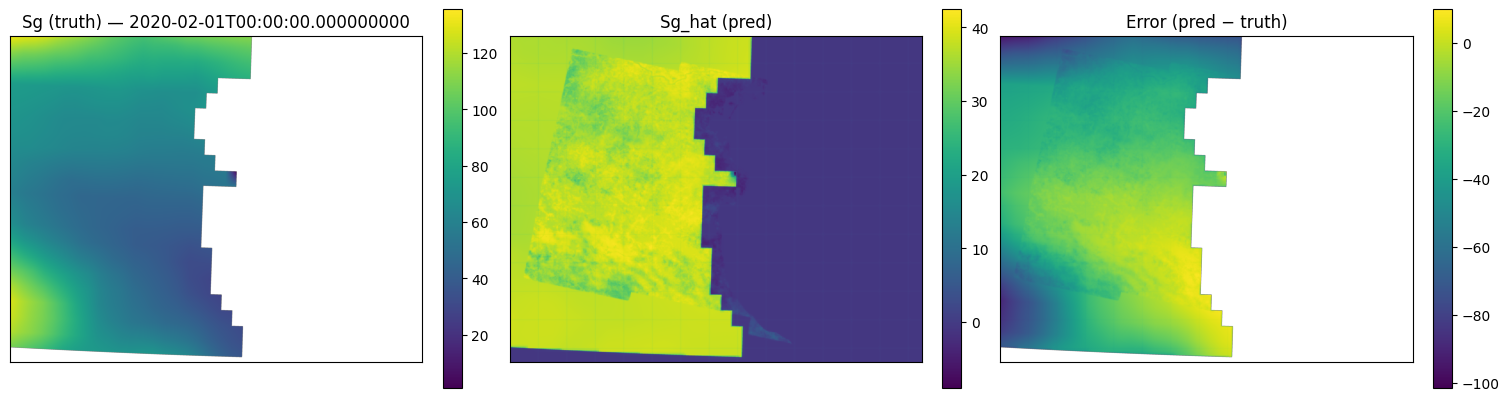

In [13]:
# === Tri-panel for one date ===
date_idx = T // 2                    # or choose any index 0..T-1

date     = str(A.time.values[date_idx])

A_t = A.isel(time=date_idx)
B_t = B.isel(time=date_idx)
E_t = A_t - B_t

fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
im0 = axs[0].imshow(B_t.values); axs[0].set_title(f"Sg (truth) — {date}"); fig.colorbar(im0, ax=axs[0], fraction=0.046)
im1 = axs[1].imshow(A_t.values); axs[1].set_title("Sg_hat (pred)");        fig.colorbar(im1, ax=axs[1], fraction=0.046)
im2 = axs[2].imshow(E_t.values); axs[2].set_title("Error (pred − truth)"); fig.colorbar(im2, ax=axs[2], fraction=0.046)
for ax in axs: ax.set_xticks([]); ax.set_yticks([])
fig.savefig(OUT / f"tri_{date.replace(':','').replace(' ','_')}.png", dpi=150)
plt.show()


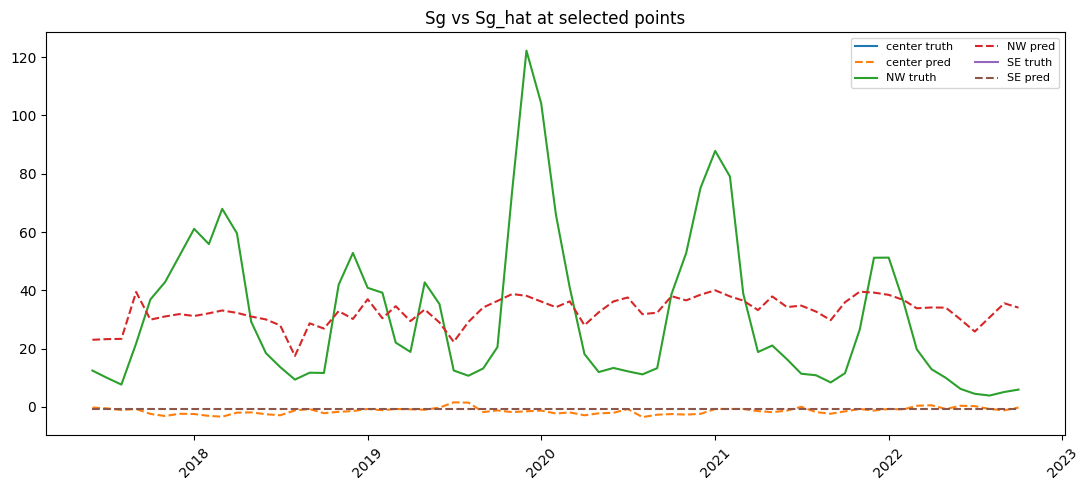

In [14]:
# === Time series at selected pixel indices ===
# TIP: change these (y,x) to interesting spots (subsidence hotspot, basin center, etc.)
pts = [
    (H//2,   W//2,   "center"),
    (H//4,   W//4,   "NW"),
    (3*H//4, 3*W//4, "SE"),
]

plt.figure(figsize=(11, 5))
for y, x, name in pts:
    ts_ref = B.isel(y=y, x=x).values
    ts_hat = A.isel(y=y, x=x).values
    tvals  = A.time.values
    plt.plot(tvals, ts_ref, label=f"{name} truth")
    plt.plot(tvals, ts_hat, linestyle="--", label=f"{name} pred")

plt.title("Sg vs Sg_hat at selected points")
plt.xticks(rotation=45); plt.legend(ncol=2, fontsize=8); plt.tight_layout()
plt.savefig(OUT / "timeseries_points.png", dpi=150)
plt.show()


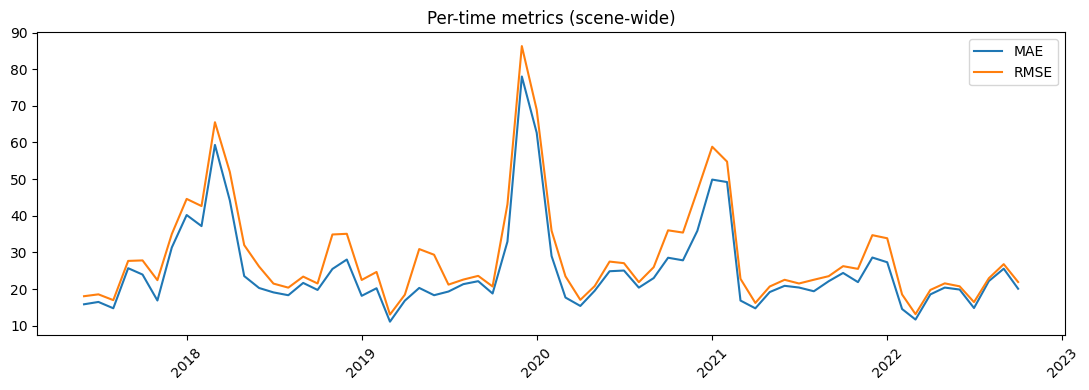

In [93]:
# === MAE & RMSE over time (full scene) ===
diff  = (A - B)
mae_t = np.abs(diff).mean(dim=("y","x")).values
rmse_t = np.sqrt(((diff**2).mean(dim=("y","x"))).values)
tvals = A.time.values

plt.figure(figsize=(11, 4))
plt.plot(tvals, mae_t, label="MAE")
plt.plot(tvals, rmse_t, label="RMSE")
plt.title("Per-time metrics (scene-wide)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
plt.savefig(OUT / "metrics_time.png", dpi=150)
plt.show()


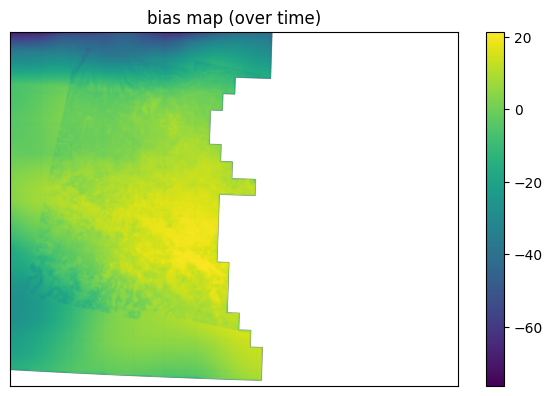

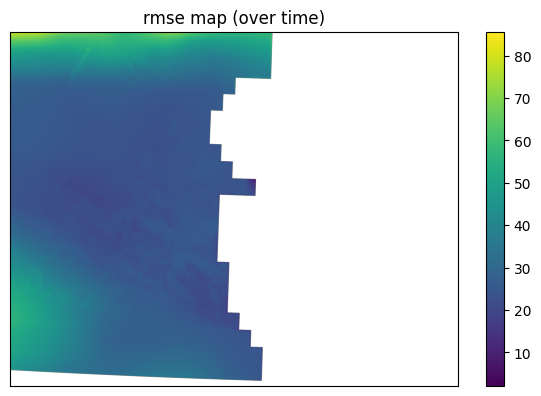

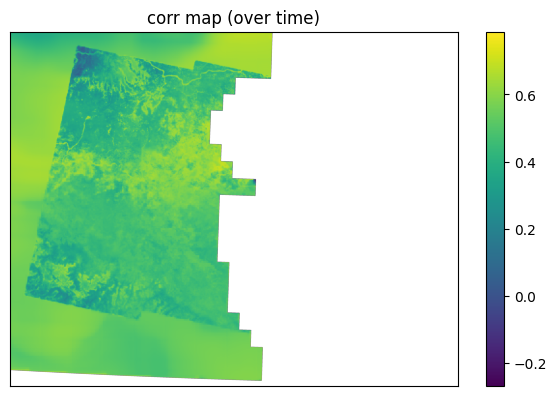

In [15]:
# === Spatial maps aggregated over time ===
diff  = A - B
bias  = diff.mean(dim="time")
rmse  = np.sqrt((diff**2).mean(dim="time"))

# Pearson correlation per pixel over time (safe epsilon to avoid /0)
A_an = A - A.mean(dim="time")
B_an = B - B.mean(dim="time")
cov  = (A_an * B_an).mean(dim="time")
stdA = np.sqrt((A_an**2).mean(dim="time"))
stdB = np.sqrt((B_an**2).mean(dim="time"))
corr = cov / (stdA * stdB + 1e-6)

maps = xr.Dataset({"bias": bias, "rmse": rmse, "corr": corr})
maps.to_netcdf(OUT / "spatial_metrics.nc")

for name in ["bias", "rmse", "corr"]:
    da = maps[name]
    plt.figure(figsize=(6, 4))
    im = plt.imshow(da.values)
    plt.title(f"{name} map (over time)")
    plt.colorbar(im)
    plt.xticks([]); plt.yticks([]); plt.tight_layout()
    plt.savefig(OUT / f"{name}_map.png", dpi=150)
    plt.show()


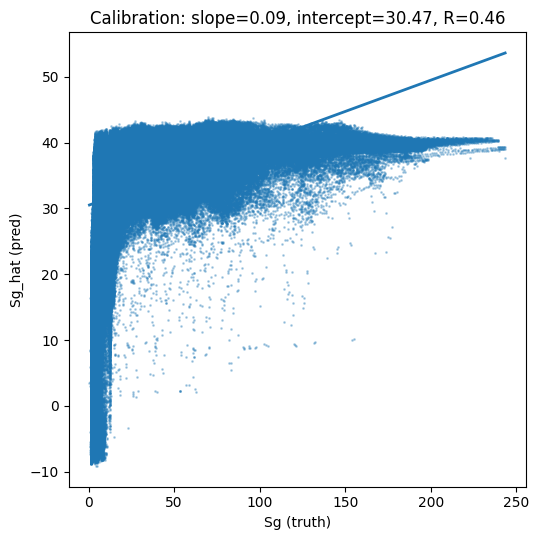

In [16]:
# === Scatter: Sg_hat vs Sg (sampled to keep it light) ===
s_t, s_y, s_x = 5, 10, 10  # strides in time, y, x
Ah = A.isel(time=slice(None, None, s_t), y=slice(None, None, s_y), x=slice(None, None, s_x)).values.reshape(-1)
Bh = B.isel(time=slice(None, None, s_t), y=slice(None, None, s_y), x=slice(None, None, s_x)).values.reshape(-1)

m = np.isfinite(Ah) & np.isfinite(Bh)
Ah = Ah[m]; Bh = Bh[m]

if Ah.size > 0:
    slope, intercept = np.polyfit(Bh, Ah, 1)
    r = np.corrcoef(Bh, Ah)[0, 1]

    plt.figure(figsize=(5.5, 5.5))
    plt.scatter(Bh, Ah, s=1, alpha=0.3)
    xx = np.linspace(Bh.min(), Bh.max(), 100)
    plt.plot(xx, slope*xx + intercept, linewidth=2)
    plt.xlabel("Sg (truth)"); plt.ylabel("Sg_hat (pred)")
    plt.title(f"Calibration: slope={slope:.2f}, intercept={intercept:.2f}, R={r:.2f}")
    plt.tight_layout(); plt.savefig(OUT / "scatter_calibration.png", dpi=150); plt.show()
else:
    print("No finite samples for scatter (check data ranges/NaNs).")


In [17]:
import numpy as np, xarray as xr, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

OUT_TAB = BASE / "reports"; OUT_TAB.mkdir(parents=True, exist_ok=True)
OUT_FIG = BASE / "figs";    OUT_FIG.mkdir(parents=True, exist_ok=True)

# Load files
pred = xr.open_dataset(BASE/"sg_predicted.nc")         # Sg_hat(time,y,x)
dsw  = xr.open_dataset(BASE/"w3ra_aligned_new.nc")     # Sg(time,y,x)
dsi  = xr.open_dataset(BASE/"insar_aligned_new.nc")    # insar_deformation(time,y,x)

# Align prediction and truth by time
A, B = xr.align(pred["Sg_hat"].astype("float32"),
                dsw["Sg"].astype("float32"),
                join="inner")

# Get lat/lon (2D or 1D) if present
lat = dsi.coords.get("lat")
lon = dsi.coords.get("lon")

def plot_geo(da, title, fname, cmap="viridis"):
    """Plot DataArray on lon/lat if available; otherwise simple imshow."""
    plt.figure(figsize=(7, 5))
    if (lat is not None) and (lon is not None):
        # Works for 2D or broadcastable 1D lat/lon
        plt.pcolormesh(lon.values, lat.values, da.values, shading="auto", cmap=cmap)
        plt.xlabel("Longitude"); plt.ylabel("Latitude")
    else:
        plt.imshow(da.values, cmap=cmap)
        plt.xlabel("x"); plt.ylabel("y")
    plt.title(title); plt.colorbar()
    plt.tight_layout(); plt.savefig(OUT_FIG/fname, dpi=150); plt.show()


A1) Overall + per-time metrics csv  

In [18]:
# Diff
diff = A - B

# Per-time
mae_t  = np.abs(diff).mean(dim=("y","x")).values
rmse_t = np.sqrt(((diff**2).mean(dim=("y","x"))).values)
bias_t = diff.mean(dim=("y","x")).values

def corr_over_space_per_time(A, B):
    A_an = A - A.mean(dim=("y","x"))
    B_an = B - B.mean(dim=("y","x"))
    cov  = (A_an * B_an).mean(dim=("y","x"))
    stdA = np.sqrt((A_an**2).mean(dim=("y","x")))
    stdB = np.sqrt((B_an**2).mean(dim=("y","x")))
    return cov / (stdA * stdB + 1e-8)

r_t = corr_over_space_per_time(A, B).values

df_time = pd.DataFrame({
    "time": A.time.values.astype("datetime64[ns]"),
    "MAE": mae_t, "RMSE": rmse_t, "Bias": bias_t, "R": r_t
})
df_time.to_csv(OUT_TAB/"metrics_per_time.csv", index=False)
print("Wrote:", OUT_TAB/"metrics_per_time.csv")

# Overall
flat_A = A.values.reshape(-1); flat_B = B.values.reshape(-1)
m = np.isfinite(flat_A) & np.isfinite(flat_B)
df_overall = pd.DataFrame([{
    "MAE":  float(np.mean(np.abs(flat_A[m]-flat_B[m]))),
    "RMSE": float(np.sqrt(np.mean((flat_A[m]-flat_B[m])**2))),
    "Bias": float(np.mean(flat_A[m]-flat_B[m])),
    "R":    float(np.corrcoef(flat_B[m], flat_A[m])[0,1]),
}])
df_overall.to_csv(OUT_TAB/"metrics_overall.csv", index=False)
print("Wrote:", OUT_TAB/"metrics_overall.csv")


Wrote: /mnt/data/data_bologna_swin_test/reports/metrics_per_time.csv
Wrote: /mnt/data/data_bologna_swin_test/reports/metrics_overall.csv


In [ ]:
tid = int(A.sizes["time"]//2)              # choose a date to show
date_str = str(A.time.values[tid])
sg_true = B.isel(time=tid)
sg_hat  = A.isel(time=tid)
err     = sg_hat - sg_true

plot_geo(sg_true, f"Sg (W3RA) — {date_str}", f"map_sg_truth_{tid}.png")
plot_geo(sg_hat,  f"Sĝ (Swin) — {date_str}", f"map_sg_hat_{tid}.png")
plot_geo(err,     f"Error (Sĝ − Sg) — {date_str}", f"map_sg_error_{tid}.png", cmap="bwr")


B2) InSAR velocity map (linear trend over time)

This computes a simple least-squares slope per pixel.
Units will be “deformation per time-step”. If your time step is monthly, multiply by ~12 for per-year.

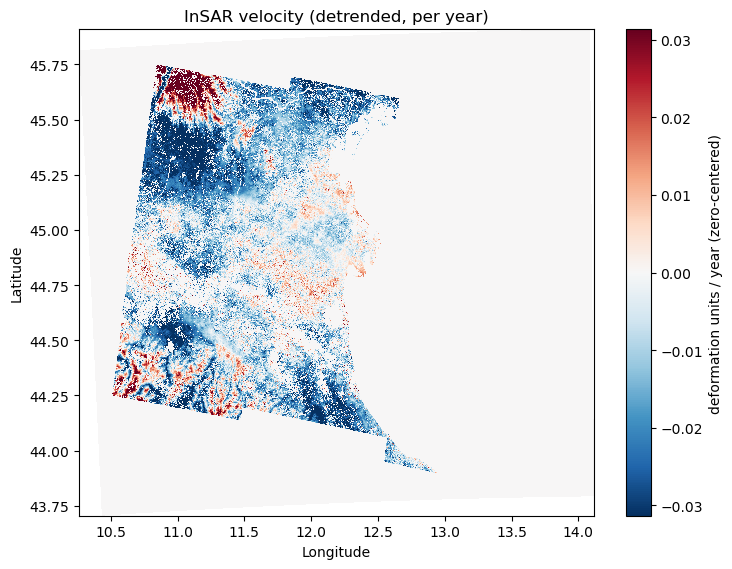

In [ ]:
import numpy as np, xarray as xr, matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

dsi = xr.open_dataset(BASE/"insar_aligned_new.nc")
uz  = dsi["insar_deformation"].astype("float32")        # (time,y,x)
lat = dsi.coords.get("lat"); lon = dsi.coords.get("lon")

# -- linear slope per pixel (least-squares)
t = np.arange(uz.sizes["time"], dtype=np.float32)
t = t - t.mean()
num = (uz * t[:,None,None]).sum(dim="time")
den = float((t**2).sum())
vel = (num / den)                                        # per time-step

# -- optional: convert to per-year if cadence ~ monthly or daily
if "time" in dsi:
    dt_days = np.median(np.diff(dsi.time.values).astype("timedelta64[D]").astype(float))
    steps_per_year = 365.25 / max(dt_days, 1.0)          # ~12 for monthly, ~365 for daily
else:
    steps_per_year = 12.0
vel_per_year = vel * steps_per_year

# -- zero-center (remove spatial median) to enhance contrast (optional but helpful)
median_bg = float(np.nanmedian(vel_per_year.values))
vel_0 = (vel_per_year - median_bg)

# -- mask outside footprint (transparent NaNs)
valid = np.isfinite(uz).any("time")
vel_0 = vel_0.where(valid)

# -- robust clipping around zero for nice contrast
p = np.nanpercentile(vel_0.values, [2, 98])
# make it symmetric around 0
m = max(abs(p[0]), abs(p[1]))
vmin, vmax = -m, m

# -- plot
cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad(alpha=0)                                    # transparent background
norm = TwoSlopeNorm(vcenter=0.0, vmin=vmin, vmax=vmax)

plt.figure(figsize=(7.5,5.8))
if (lat is not None) and (lon is not None):
    plt.pcolormesh(lon.values, lat.values, vel_0.values, cmap=cmap, norm=norm, shading="auto")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
else:
    plt.imshow(vel_0.values, cmap=cmap, norm=norm)
    plt.xlabel("x"); plt.ylabel("y")

plt.title("InSAR velocity (detrended, per year)")
cb = plt.colorbar()
cb.set_label("deformation units / year (zero-centered)")
plt.tight_layout()
#plt.savefig(BASE/"plots/map_insar_velocity_enhanced.png", dpi=150)
plt.show()


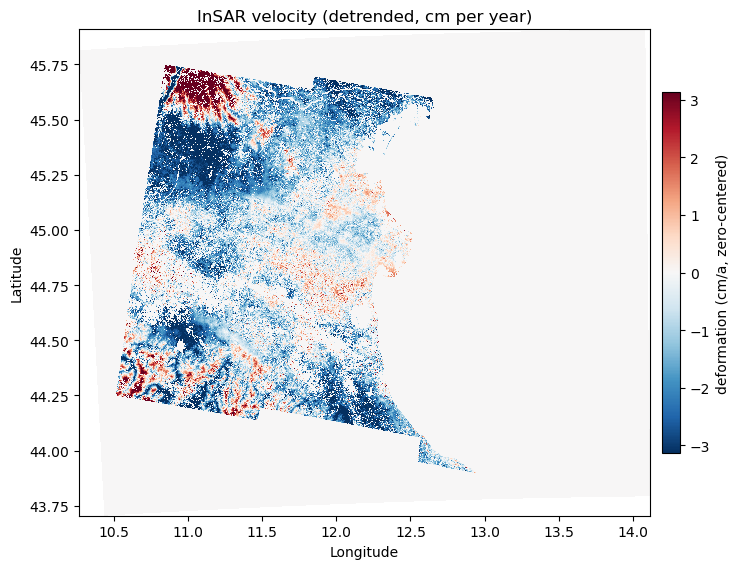

In [5]:
# -- mask outside footprint (transparent NaNs)
valid = np.isfinite(uz).any("time")
vel_0 = vel_0.where(valid)

# === convert m/a -> cm/a ===
vel_cm = vel_0 * 100.0    # now in cm per year

# -- robust clipping around zero for nice contrast (on cm/a)
v = vel_cm.values
v = v[np.isfinite(v)]
p2, p98 = np.percentile(v, [2, 98])
m = max(abs(p2), abs(p98))
vmin, vmax = -m, m

# -- plot ---
cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad(alpha=0)  # transparent for NaNs
norm = TwoSlopeNorm(vcenter=0.0, vmin=vmin, vmax=vmax)

plt.figure(figsize=(7.5, 5.8))
if (lat is not None) and (lon is not None):
    im = plt.pcolormesh(
        lon.values, lat.values, vel_cm.values,
        cmap=cmap, norm=norm, shading="auto"
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
else:
    im = plt.imshow(vel_cm.values, cmap=cmap, norm=norm)
    plt.xlabel("x")
    plt.ylabel("y")

# smaller colorbar (fraction controls length; pad = distance from plot)
cb = plt.colorbar(im, fraction=0.03, pad=0.02)
cb.set_label("deformation (cm/a, zero-centered)")

plt.title("InSAR velocity (detrended, cm per year)")
plt.tight_layout()
plt.savefig(BASE / "plots/map_insar_velocity_cm_per_year.png", dpi=150)
plt.show()


Plots of: 
S0, Sd, Sg from w3ra_aligned_new.nc, and

Sg_hat from sg_predicted.nc

It saves both absolute maps (sequential colormap) and anomaly maps (zero-centered, diverging colormap) for a chosen time step.

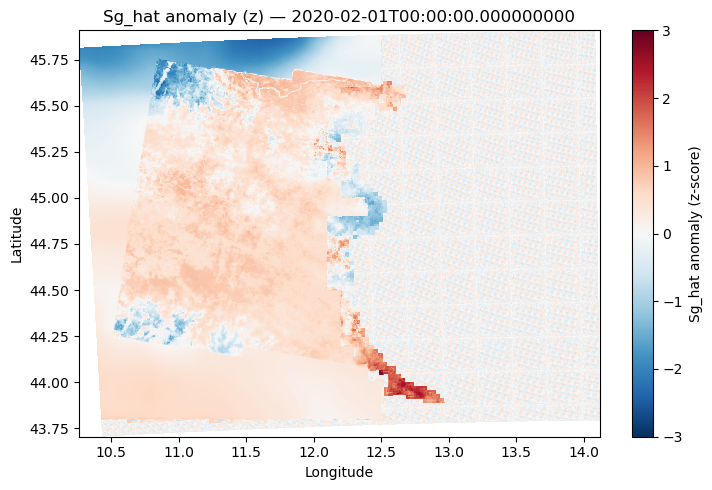

In [6]:
# === Sg_hat anomaly map (z-score over time) ===
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

BASE = Path(BASE)  # if BASE already defined you can delete this line

# Load prediction and lat/lon (footprint) info
pred = xr.open_dataset(BASE / "sg_predicted.nc")     # contains Sg_hat(time, y, x)
dsi  = xr.open_dataset(BASE / "insar_aligned_new.nc")  # just to get lat/lon
Sg_hat = pred["Sg_hat"].astype("float32")

lat = dsi.coords.get("lat")
lon = dsi.coords.get("lon")

# --- temporal anomalies (z-score) per pixel ---
mu  = Sg_hat.mean(dim="time")
std = Sg_hat.std(dim="time")
Sg_hat_anom = (Sg_hat - mu) / (std + 1e-6)   # avoid div-by-zero

# choose which time to plot (middle time step by default)
tid  = int(Sg_hat.sizes["time"] // 2)
tval = str(Sg_hat.time.values[tid])

da = Sg_hat_anom.isel(time=tid)

plt.figure(figsize=(7.5, 5))
if (lat is not None) and (lon is not None):
    im = plt.pcolormesh(
        lon.values, lat.values, da.values,
        shading="auto", cmap="RdBu_r", vmin=-3, vmax=3
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
else:
    im = plt.imshow(da.values, cmap="RdBu_r", vmin=-3, vmax=3)
    plt.xlabel("x")
    plt.ylabel("y")

cb = plt.colorbar(im)
cb.set_label("Sg_hat anomaly (z-score)")
plt.title(f"Sg_hat anomaly (z) — {tval}")
plt.tight_layout()

OUT = BASE / "figs"
OUT.mkdir(exist_ok=True, parents=True)
#plt.savefig(OUT / f"map_sg_hat_anom_z_{tid}.png", dpi=150)
plt.show()


In [7]:
# === Sg_hat trend map with auto scaling (velocity-style, model units / year) ===
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path

OUT = BASE / "plots"
OUT.mkdir(exist_ok=True, parents=True)

# Load predicted Sg_hat and lat/lon + footprint
pred = xr.open_dataset(BASE / "sg_predicted.nc")       # Sg_hat(time, y, x)
dsi  = xr.open_dataset(BASE / "insar_aligned_new.nc")  # for lat/lon + footprint

Sg_hat = pred["Sg_hat"].astype("float32")
lat = dsi.coords.get("lat")
lon = dsi.coords.get("lon")

foot = np.isfinite(dsi["insar_deformation"]).any("time")  # InSAR footprint mask

# --- time axis in years ---
t0 = np.datetime64("2000-01-01")
t_years = (Sg_hat.time.values - t0) / np.timedelta64(1, "D") / 365.25
Sg_hat_t = Sg_hat.assign_coords(time=("time", t_years))

# --- linear trend per pixel ---
pf = Sg_hat_t.polyfit(dim="time", deg=1, skipna=True)
slope = pf["polyfit_coefficients"].sel(degree=1)   # [model units / year]
vel = slope.where(foot)

# --- robust symmetric color limits around 0 ---
v = vel.values
v = v[np.isfinite(v)]
p2, p98 = np.percentile(v, [2, 98])
vmax = float(max(abs(p2), abs(p98)))
norm = TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)


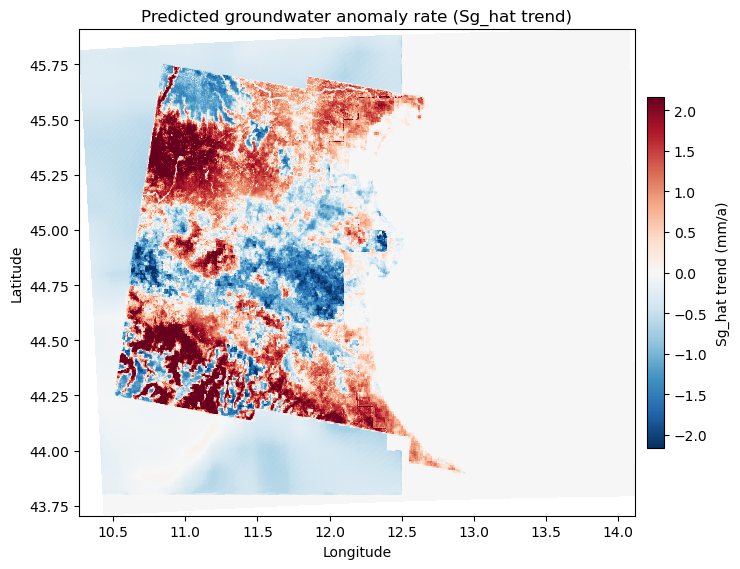

In [8]:
cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad(alpha=0)   # transparent for NaNs

plt.figure(figsize=(7.5, 5.8))
if (lat is not None) and (lon is not None):
    im = plt.pcolormesh(
        lon.values, lat.values, vel.values,
        shading="auto", cmap=cmap, norm=norm
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
else:
    im = plt.imshow(vel.values, cmap=cmap, norm=norm)
    plt.xlabel("x")
    plt.ylabel("y")

# smaller, slimmer colorbar
cb = plt.colorbar(im, fraction=0.03, pad=0.02)
cb.set_label("Sg_hat trend (mm/a)", labelpad=6)
plt.title("Predicted groundwater anomaly rate (Sg_hat trend)")
plt.tight_layout()
#plt.savefig(OUT / "sg_hat_trend_auto_scaled.png", dpi=150)
plt.show()


In [9]:
import sys, matplotlib

print("Python:", sys.executable)
print("Backend before:", matplotlib.get_backend())

try:
    import ipympl
    print("ipympl version:", ipympl.__version__)
except Exception as e:
    print("ipympl import error:", e)


Python: /home/ubuntu/anaconda3/envs/swin_env/bin/python
Backend before: module://matplotlib_inline.backend_inline
ipympl version: 0.9.8


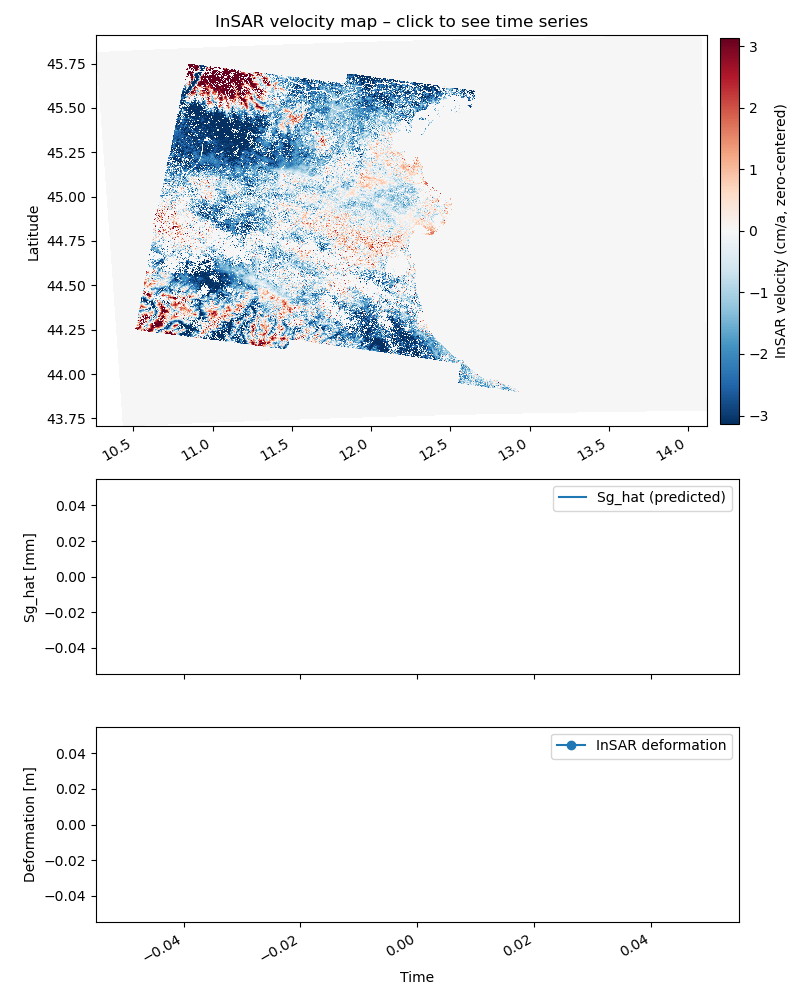

In [29]:
%matplotlib widget

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path
import matplotlib.dates as mdates

BASE = Path(BASE)

# --- Load data ---
dsi  = xr.open_dataset(BASE / "insar_aligned_new.nc")   # insar_deformation(time,y,x)
pred = xr.open_dataset(BASE / "sg_predicted.nc")        # Sg_hat(time,y,x)

insar  = dsi["insar_deformation"].astype("float32")
Sg_hat = pred["Sg_hat"].astype("float32")

# Align in time
Sg_hat, insar = xr.align(Sg_hat, insar, join="inner")

lat = dsi.coords.get("lat")
lon = dsi.coords.get("lon")

# --- InSAR velocity map (cm/a, detrended) ---
uz = insar  # (time,y,x)

# time coordinate as DataArray
t = xr.DataArray(np.arange(uz.sizes["time"], dtype=np.float32), dims=("time",))
t = t - t.mean("time")

num = (uz * t).sum(dim="time")
den = float((t**2).sum())
vel_per_step = num / den

dt_days = np.median(np.diff(uz.time.values).astype("timedelta64[D]").astype(float))
steps_per_year = 365.25 / max(dt_days, 1.0)
vel_per_year_m = vel_per_step * steps_per_year  # m/a

median_m = float(np.nanmedian(vel_per_year_m.values))
vel_insar_m = vel_per_year_m - median_m         # zero-centered
valid = np.isfinite(uz).any("time")
vel_insar_cm = (vel_insar_m * 100.0).where(valid)  # cm/a

# color scaling
v = vel_insar_cm.values
v = v[np.isfinite(v)]
p2, p98 = np.percentile(v, [2, 98])
m = max(abs(p2), abs(p98))
norm = TwoSlopeNorm(vcenter=0.0, vmin=-m, vmax=m)

# --- Figure with 3 panels: map + 2 time series ---
fig, (ax_map, ax_gw, ax_def) = plt.subplots(
    3, 1, figsize=(8, 10),
    gridspec_kw={"height_ratios": [2, 1, 1]}
)

# Map
cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad(alpha=0)

if (lat is not None) and (lon is not None):
    im = ax_map.pcolormesh(
        lon.values, lat.values, vel_insar_cm.values,
        cmap=cmap, norm=norm, shading="auto"
    )
    #ax_map.set_xlabel("Longitude")
    ax_map.set_ylabel("Latitude")
else:
    im = ax_map.imshow(vel_insar_cm.values, cmap=cmap, norm=norm)
    ax_map.set_xlabel("x")
    ax_map.set_ylabel("y")

cb = plt.colorbar(im, ax=ax_map, fraction=0.03, pad=0.02)
cb.set_label("InSAR velocity (cm/a, zero-centered)")

ax_map.set_title("InSAR velocity map – click to see time series")

# Empty time-series lines (groundwater prediction + deformation)
(line_sg_hat,) = ax_gw.plot([], [], label="Sg_hat (predicted)")
ax_gw.set_ylabel("Sg_hat [mm]")
ax_gw.legend()

(line_def,) = ax_def.plot([], [], "o-", label="InSAR deformation")
ax_def.set_ylabel("Deformation [m]")
ax_def.legend()

for ax in (ax_gw, ax_def):
    ax.set_xlabel("Time")

fig.autofmt_xdate()

# --- Click callback ---
def onclick(event):
    if event.inaxes is not ax_map:
        return
    if event.xdata is None or event.ydata is None:
        return

    xclick = float(event.xdata)
    yclick = float(event.ydata)

    # find nearest grid index (iy, ix) from lon/lat or pixel coords
    if (lat is not None) and (lon is not None):
        LON = lon.values
        LAT = lat.values
        if LON.ndim == 1 and LAT.ndim == 1:
            ix = int(np.argmin(np.abs(LON - xclick)))
            iy = int(np.argmin(np.abs(LAT - yclick)))
            lon_pt = float(LON[ix])
            lat_pt = float(LAT[iy])
        else:
            dist2 = (LON - xclick) ** 2 + (LAT - yclick) ** 2
            iy, ix = np.unravel_index(np.nanargmin(dist2), dist2.shape)
            lon_pt = float(LON[iy, ix])
            lat_pt = float(LAT[iy, ix])
        loc_txt = f"lon={lon_pt:.3f}, lat={lat_pt:.3f}"
    else:
        ix = int(round(xclick))
        iy = int(round(yclick))
        loc_txt = f"x={ix}, y={iy}"

    sg_hat_pt = Sg_hat.isel(y=iy, x=ix)
    def_pt    = insar.isel(y=iy, x=ix)

    # convert time to Matplotlib date numbers
    tvals = sg_hat_pt["time"].values
    tnum  = mdates.date2num(tvals)

    # update groundwater panel
    line_sg_hat.set_data(tnum, sg_hat_pt.values)
    ax_gw.relim()
    ax_gw.autoscale_view()
    ax_gw.set_title(f"Sg_hat at {loc_txt}")

    # update deformation panel
    line_def.set_data(tnum, def_pt.values)
    ax_def.relim()
    ax_def.autoscale_view()
    ax_def.set_title(f"InSAR deformation at {loc_txt}")

    # date formatting for both panels
    for ax in (ax_gw, ax_def):
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    fig.autofmt_xdate()

    fig.canvas.draw_idle()


fig.canvas.mpl_connect("button_press_event", onclick)

plt.tight_layout()
plt.show()



In [24]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


NameError: name 'cmap' is not defined

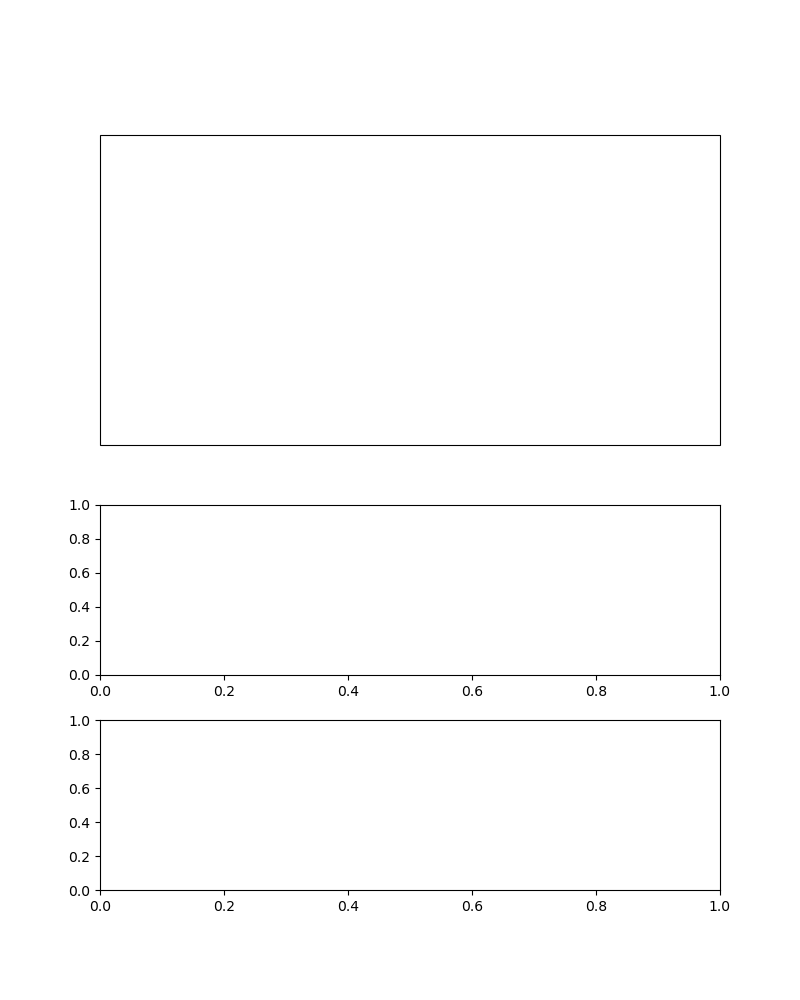

In [28]:
%matplotlib widget

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path
import matplotlib.dates as mdates
import cartopy.io.img_tiles as cimgt

BASE = Path(BASE)

# --- Load data ---
dsi  = xr.open_dataset(BASE / "insar_aligned_new.nc")   # insar_deformation(time,y,x)
pred = xr.open_dataset(BASE / "sg_predicted.nc")        # Sg_hat(time,y,x)

insar  = dsi["insar_deformation"].astype("float32")
Sg_hat = pred["Sg_hat"].astype("float32")

# Align in time
Sg_hat, insar = xr.align(Sg_hat, insar, join="inner")

lat = dsi.coords.get("lat")
lon = dsi.coords.get("lon")

# --- InSAR velocity map (cm/a, detrended) ---
uz = insar  # (time,y,x)

# time coordinate as DataArray
t = xr.DataArray(np.arange(uz.sizes["time"], dtype=np.float32), dims=("time",))
t = t - t.mean("time")

num = (uz * t).sum(dim="time")
den = float((t**2).sum())
vel_per_step = num / den

dt_days = np.median(np.diff(uz.time.values).astype("timedelta64[D]").astype(float))
steps_per_year = 365.25 / max(dt_days, 1.0)
vel_per_year_m = vel_per_step * steps_per_year  # m/a

median_m = float(np.nanmedian(vel_per_year_m.values))
vel_insar_m = vel_per_year_m - median_m         # zero-centered
valid = np.isfinite(uz).any("time")
vel_insar_cm = (vel_insar_m * 100.0).where(valid)  # cm/a

# color scaling
v = vel_insar_cm.values
v = v[np.isfinite(v)]
p2, p98 = np.percentile(v, [2, 98])
m = max(abs(p2), abs(p98))
norm = TwoSlopeNorm(vcenter=0.0, vmin=-m, vmax=m)

proj = ccrs.PlateCarree()

# make map axis with a projection, then two normal axes for TS
fig = plt.figure(figsize=(8, 10))
gs  = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])

ax_map = fig.add_subplot(gs[0, 0], projection=proj)
ax_gw  = fig.add_subplot(gs[1, 0])
ax_def = fig.add_subplot(gs[2, 0])

# --- map with basemap ---
if (lat is not None) and (lon is not None):
    im = ax_map.pcolormesh(
        lon.values, lat.values, vel_insar_cm.values,
        cmap=cmap, vmin=vmin, vmax=vmax,
        shading="auto", transform=proj
    )

    # extent from your data
    lon_min = float(np.nanmin(lon.values))
    lon_max = float(np.nanmax(lon.values))
    lat_min = float(np.nanmin(lat.values))
    lat_max = float(np.nanmax(lat.values))
    ax_map.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)

    # add coastlines and borders
    ax_map.coastlines(resolution="10m", linewidth=0.7)
    ax_map.add_feature(cfeature.BORDERS, linewidth=0.6)
    ax_map.add_feature(cfeature.LAKES, edgecolor="k", facecolor="none", linewidth=0.4)

    ax_map.set_xlabel("Longitude")
    ax_map.set_ylabel("Latitude")
else:
    # fallback for no lat/lon
    im = ax_map.imshow(vel_insar_cm.values, cmap=cmap, vmin=vmin, vmax=vmax)
    ax_map.set_xlabel("x")
    ax_map.set_ylabel("y")

cb = plt.colorbar(im, ax=ax_map, fraction=0.03, pad=0.02)
cb.set_label("InSAR velocity (cm/a)")

ax_map.set_title("InSAR velocity map – click to see time series")


# Empty time-series lines (groundwater prediction + deformation)
(line_sg_hat,) = ax_gw.plot([], [], label="Sg_hat (predicted)")
ax_gw.set_ylabel("Sg_hat [mm]")
ax_gw.legend()

(line_def,) = ax_def.plot([], [], "o-", label="InSAR deformation")
ax_def.set_ylabel("Deformation [m]")
ax_def.legend()

for ax in (ax_gw, ax_def):
    ax.set_xlabel("Time")

fig.autofmt_xdate()

# --- Click callback ---
def onclick(event):
    if event.inaxes is not ax_map:
        return
    if event.xdata is None or event.ydata is None:
        return

    xclick = float(event.xdata)
    yclick = float(event.ydata)

    # find nearest grid index (iy, ix) from lon/lat or pixel coords
    if (lat is not None) and (lon is not None):
        LON = lon.values
        LAT = lat.values
        if LON.ndim == 1 and LAT.ndim == 1:
            ix = int(np.argmin(np.abs(LON - xclick)))
            iy = int(np.argmin(np.abs(LAT - yclick)))
            lon_pt = float(LON[ix])
            lat_pt = float(LAT[iy])
        else:
            dist2 = (LON - xclick) ** 2 + (LAT - yclick) ** 2
            iy, ix = np.unravel_index(np.nanargmin(dist2), dist2.shape)
            lon_pt = float(LON[iy, ix])
            lat_pt = float(LAT[iy, ix])
        loc_txt = f"lon={lon_pt:.3f}, lat={lat_pt:.3f}"
    else:
        ix = int(round(xclick))
        iy = int(round(yclick))
        loc_txt = f"x={ix}, y={iy}"

    sg_hat_pt = Sg_hat.isel(y=iy, x=ix)
    def_pt    = insar.isel(y=iy, x=ix)

    # convert time to Matplotlib date numbers
    tvals = sg_hat_pt["time"].values
    tnum  = mdates.date2num(tvals)

    # update groundwater panel
    line_sg_hat.set_data(tnum, sg_hat_pt.values)
    ax_gw.relim()
    ax_gw.autoscale_view()
    ax_gw.set_title(f"Sg_hat at {loc_txt}")

    # update deformation panel
    line_def.set_data(tnum, def_pt.values)
    ax_def.relim()
    ax_def.autoscale_view()
    ax_def.set_title(f"InSAR deformation at {loc_txt}")

    # date formatting for both panels
    for ax in (ax_gw, ax_def):
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    fig.autofmt_xdate()

    fig.canvas.draw_idle()


fig.canvas.mpl_connect("button_press_event", onclick)

plt.tight_layout()
plt.show()

In [26]:
%matplotlib widget

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path
import matplotlib.dates as mdates
import cartopy.io.img_tiles as cimgt

BASE = Path(BASE)

# --- Load data ---
dsi  = xr.open_dataset(BASE / "insar_aligned_new.nc")   # insar_deformation(time,y,x)
pred = xr.open_dataset(BASE / "sg_predicted.nc")        # Sg_hat(time,y,x)

insar  = dsi["insar_deformation"].astype("float32")
Sg_hat = pred["Sg_hat"].astype("float32")

# Align in time
Sg_hat, insar = xr.align(Sg_hat, insar, join="inner")

lat = dsi.coords.get("lat")
lon = dsi.coords.get("lon")

# --- InSAR velocity map (cm/a, detrended) ---
uz = insar  # (time,y,x)

# time coordinate as DataArray
t = xr.DataArray(np.arange(uz.sizes["time"], dtype=np.float32), dims=("time",))
t = t - t.mean("time")

num = (uz * t).sum(dim="time")
den = float((t**2).sum())
vel_per_step = num / den

dt_days = np.median(np.diff(uz.time.values).astype("timedelta64[D]").astype(float))
steps_per_year = 365.25 / max(dt_days, 1.0)
vel_per_year_m = vel_per_step * steps_per_year  # m/a

median_m = float(np.nanmedian(vel_per_year_m.values))
vel_insar_m = vel_per_year_m - median_m         # zero-centered
valid = np.isfinite(uz).any("time")
vel_insar_cm = (vel_insar_m * 100.0).where(valid)  # cm/a

# color scaling
v = vel_insar_cm.values
v = v[np.isfinite(v)]
p2, p98 = np.percentile(v, [2, 98])
m = max(abs(p2), abs(p98))
norm = TwoSlopeNorm(vcenter=0.0, vmin=-m, vmax=m)

import rasterio
from rasterio.plot import reshape_as_image
import cartopy.crs as ccrs

# read local raster
with rasterio.open("/path/to/your/ortho.tif") as src:
    img = src.read()                 # (bands, rows, cols)
    img = reshape_as_image(img)      # (rows, cols, bands)
    bounds = src.bounds              # left, bottom, right, top
    raster_crs = ccrs.epsg(src.crs.to_epsg())

# in your map code:
ax_map = fig.add_subplot(gs[0, 0], projection=raster_crs)

ax_map.imshow(
    img,
    origin="upper",
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    transform=raster_crs
)

# then overlay InSAR, transformed properly:
im = ax_map.pcolormesh(
    lon.values, lat.values, vel_insar_cm.values,
    cmap=cmap, vmin=vmin, vmax=vmax,
    shading="auto", transform=ccrs.PlateCarree()
)



# Empty time-series lines (groundwater prediction + deformation)
(line_sg_hat,) = ax_gw.plot([], [], label="Sg_hat (predicted)")
ax_gw.set_ylabel("Sg_hat [mm]")
ax_gw.legend()

(line_def,) = ax_def.plot([], [], "o-", label="InSAR deformation")
ax_def.set_ylabel("Deformation [m]")
ax_def.legend()

for ax in (ax_gw, ax_def):
    ax.set_xlabel("Time")

fig.autofmt_xdate()

# --- Click callback ---
def onclick(event):
    if event.inaxes is not ax_map:
        return
    if event.xdata is None or event.ydata is None:
        return

    xclick = float(event.xdata)
    yclick = float(event.ydata)

    # find nearest grid index (iy, ix) from lon/lat or pixel coords
    if (lat is not None) and (lon is not None):
        LON = lon.values
        LAT = lat.values
        if LON.ndim == 1 and LAT.ndim == 1:
            ix = int(np.argmin(np.abs(LON - xclick)))
            iy = int(np.argmin(np.abs(LAT - yclick)))
            lon_pt = float(LON[ix])
            lat_pt = float(LAT[iy])
        else:
            dist2 = (LON - xclick) ** 2 + (LAT - yclick) ** 2
            iy, ix = np.unravel_index(np.nanargmin(dist2), dist2.shape)
            lon_pt = float(LON[iy, ix])
            lat_pt = float(LAT[iy, ix])
        loc_txt = f"lon={lon_pt:.3f}, lat={lat_pt:.3f}"
    else:
        ix = int(round(xclick))
        iy = int(round(yclick))
        loc_txt = f"x={ix}, y={iy}"

    sg_hat_pt = Sg_hat.isel(y=iy, x=ix)
    def_pt    = insar.isel(y=iy, x=ix)

    # convert time to Matplotlib date numbers
    tvals = sg_hat_pt["time"].values
    tnum  = mdates.date2num(tvals)

    # update groundwater panel
    line_sg_hat.set_data(tnum, sg_hat_pt.values)
    ax_gw.relim()
    ax_gw.autoscale_view()
    ax_gw.set_title(f"Sg_hat at {loc_txt}")

    # update deformation panel
    line_def.set_data(tnum, def_pt.values)
    ax_def.relim()
    ax_def.autoscale_view()
    ax_def.set_title(f"InSAR deformation at {loc_txt}")

    # date formatting for both panels
    for ax in (ax_gw, ax_def):
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    fig.autofmt_xdate()

    fig.canvas.draw_idle()


fig.canvas.mpl_connect("button_press_event", onclick)

plt.tight_layout()
plt.show()

RasterioIOError: /path/to/your/ortho.tif: No such file or directory

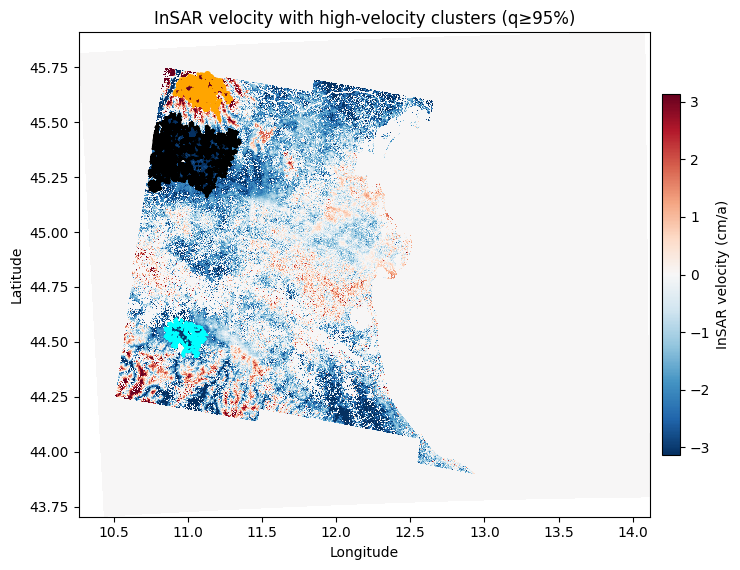

TypeError: unsupported operand type(s) for +: 'Axes' and 'Axes'

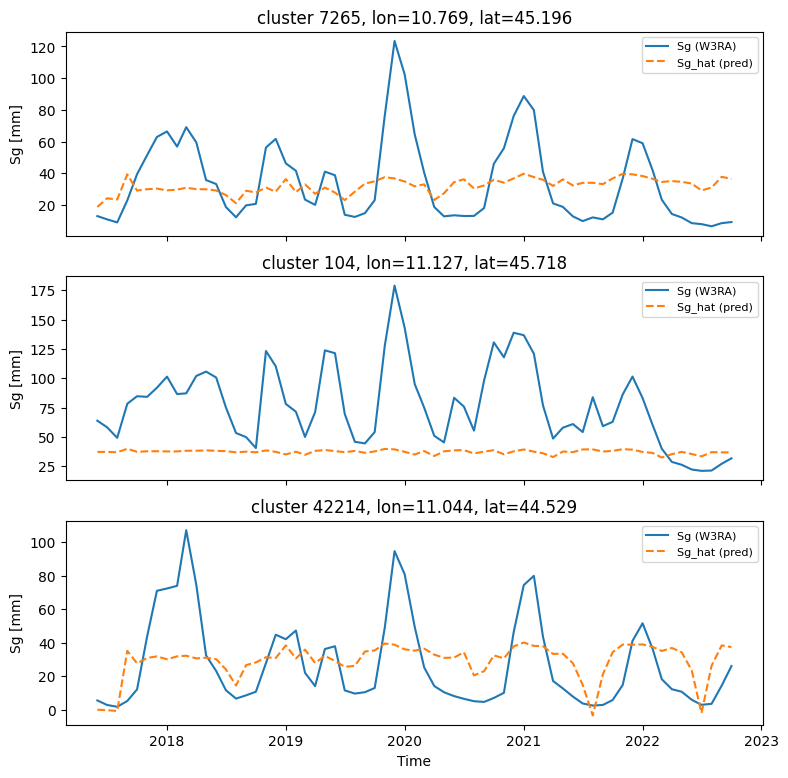

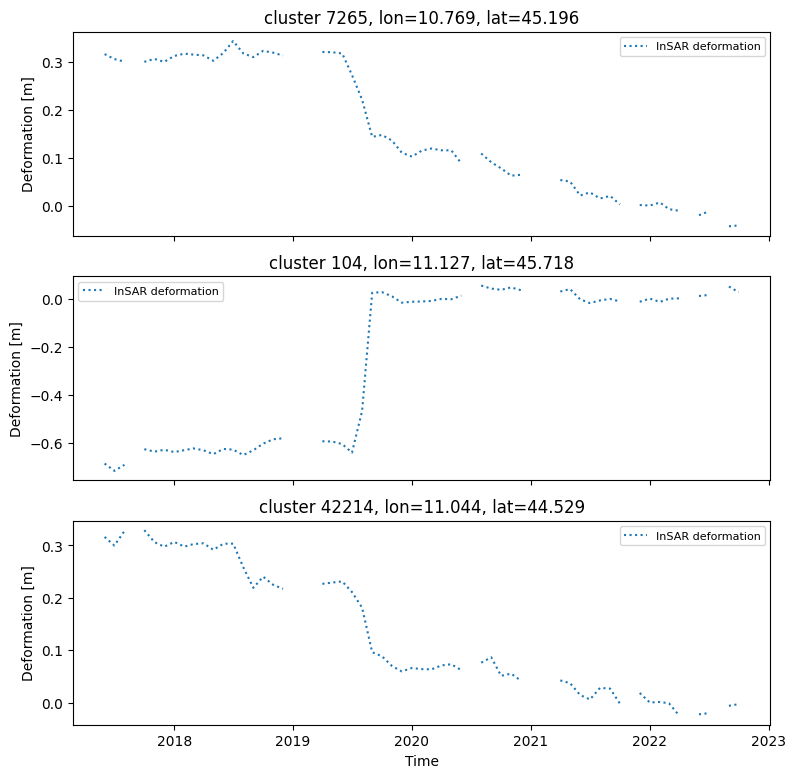

In [57]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy import ndimage as ndi
from pathlib import Path

# ------------------------------------------------------------------
# Load data & align
# ------------------------------------------------------------------
BASE = Path(BASE)

dsi  = xr.open_dataset(BASE / "insar_aligned_new.nc")   # insar_deformation(time,y,x)
dsw  = xr.open_dataset(BASE / "w3ra_aligned_new.nc")    # Sg(time,y,x)
pred = xr.open_dataset(BASE / "sg_predicted.nc")        # Sg_hat(time,y,x)

insar  = dsi["insar_deformation"].astype("float32")
Sg     = dsw["Sg"].astype("float32")
Sg_hat = pred["Sg_hat"].astype("float32")

Sg, Sg_hat, insar = xr.align(Sg, Sg_hat, insar, join="inner")

lat = dsi.coords.get("lat")
lon = dsi.coords.get("lon")

y_dim, x_dim = insar.dims[-2:]   # typically ("y","x")

# ------------------------------------------------------------------
# --- Helper: make InSAR velocity map [cm/a], detrended ---
uz = insar  # alias: (time, y, x)

# time coordinate as DataArray
t = xr.DataArray(
    np.arange(uz.sizes["time"], dtype=np.float32),
    dims=("time",)
)
t = t - t.mean("time")

# linear slope per time-step
num = (uz * t).sum(dim="time")
den = float((t**2).sum())
vel_per_step = num / den

# convert to per year
dt_days = np.median(np.diff(uz.time.values).astype("timedelta64[D]").astype(float))
steps_per_year = 365.25 / max(dt_days, 1.0)
vel_per_year_m = vel_per_step * steps_per_year  # m/a

# zero-center and mask
median_m = float(np.nanmedian(vel_per_year_m.values))
vel_insar_m = vel_per_year_m - median_m
valid_insar = np.isfinite(uz).any("time")
vel_insar_cm = (vel_insar_m * 100.0).where(valid_insar)  # cm/a


# ------------------------------------------------------------------
# Generic clustering + plotting function
# ------------------------------------------------------------------
def cluster_and_plot(name, vel_da, unit_label, n_regions=3, q=95, min_pix=50):
    """
    vel_da: 2D DataArray (y,x) of velocity
    """
    v = vel_da.values
    mask_finite = np.isfinite(v)
    if not np.any(mask_finite):
        print(f"[{name}] No finite values.")
        return

    # threshold on absolute velocity
    thr = np.nanpercentile(np.abs(v[mask_finite]), q)
    high = (np.abs(v) >= thr) & mask_finite

    labels, nlab = ndi.label(high)
    if nlab == 0:
        print(f"[{name}] No high-velocity regions above percentile {q}.")
        return

    # sizes per label
    sizes = np.bincount(labels.ravel())
    # candidate labels sorted by size (ignore label 0)
    cand = np.argsort(sizes[1:])[::-1] + 1
    cand = [lab for lab in cand if sizes[lab] >= min_pix][:n_regions]
    if not cand:
        print(f"[{name}] No regions with at least {min_pix} pixels.")
        return

    # base map
    v_map = vel_da.values
    finite_vals = v_map[np.isfinite(v_map)]
    p2, p98 = np.percentile(finite_vals, [2, 98])
    m = max(abs(p2), abs(p98))
    norm = TwoSlopeNorm(vcenter=0.0, vmin=-m, vmax=m)

    cmap = plt.get_cmap("RdBu_r").copy()
    cmap.set_bad(alpha=0)

    fig_map, ax_map = plt.subplots(figsize=(7.5, 5.8))
    if (lat is not None) and (lon is not None):
        im = ax_map.pcolormesh(
            lon.values, lat.values, v_map,
            cmap=cmap, norm=norm, shading="auto"
        )
        ax_map.set_xlabel("Longitude")
        ax_map.set_ylabel("Latitude")
    else:
        im = ax_map.imshow(v_map, cmap=cmap, norm=norm)
        ax_map.set_xlabel("x")
        ax_map.set_ylabel("y")

    cb = plt.colorbar(im, ax=ax_map, fraction=0.03, pad=0.02)
    cb.set_label(f"{name} ({unit_label})")

    colors = ["k", "orange", "cyan", "magenta", "lime"]
    rep_points = []  # (iy, ix, label_id)

    for i, lab in enumerate(cand):
        region = (labels == lab)
        if not np.any(region):
            continue
        # outline / polygon (contour of mask)
        if (lat is not None) and (lon is not None):
            ax_map.contour(
                lon.values, lat.values, region.astype(float),
                levels=[0.5], colors=colors[i % len(colors)], linewidths=1.2
            )
        else:
            ax_map.contour(
                region.astype(float),
                levels=[0.5], colors=colors[i % len(colors)], linewidths=1.2
            )

        # representative point: max |vel| in this region
        idx = np.argwhere(region)
        vals_reg = np.abs(v_map[region])
        iy, ix = idx[np.argmax(vals_reg)]
        rep_points.append((int(iy), int(ix), lab))
        if (lat is not None) and (lon is not None):
            ax_map.plot(
                lon.values[iy, ix], lat.values[iy, ix],
                marker="o", ms=4, color=colors[i % len(colors)]
            )
        else:
            ax_map.plot(ix, iy, marker="o", ms=4, color=colors[i % len(colors)])

    ax_map.set_title(f"{name} with high-velocity clusters (q≥{q}%)")
    plt.tight_layout()
    plt.show()

    # Time series for each representative point
    n = len(rep_points)
    # Time series for each representative point
    n = len(rep_points)

    # --- Figure 1: groundwater (Sg + Sg_hat) ---
    fig_sg, axes_sg = plt.subplots(n, 1, figsize=(9, 3 * n), sharex=True)
    if n == 1:
        axes_sg = [axes_sg]

    # --- Figure 2: deformation only ---
    fig_def, axes_def = plt.subplots(n, 1, figsize=(9, 3 * n), sharex=True)
    if n == 1:
        axes_def = [axes_def]

    for (iy, ix, lab), ax_sg, ax_def in zip(rep_points, axes_sg, axes_def):
        sg_pt     = Sg.isel({y_dim: iy, x_dim: ix})
        sg_hat_pt = Sg_hat.isel({y_dim: iy, x_dim: ix})
        def_pt    = insar.isel({y_dim: iy, x_dim: ix})

        tvals = sg_pt["time"].values
        if (lat is not None) and (lon is not None):
            loc_txt = f"cluster {lab}, lon={float(lon.values[iy, ix]):.3f}, lat={float(lat.values[iy, ix]):.3f}"
        else:
            loc_txt = f"cluster {lab}, x={ix}, y={iy}"

        # Groundwater panel
        ax_sg.plot(tvals, sg_pt.values, label="Sg (W3RA)")
        ax_sg.plot(tvals, sg_hat_pt.values, "--", label="Sg_hat (pred)")
        ax_sg.set_ylabel("Sg [mm]")
        ax_sg.set_title(loc_txt)
        ax_sg.legend(fontsize=8)

        # Deformation panel
        ax_def.plot(tvals, def_pt.values, ":", label="InSAR deformation")
        ax_def.set_ylabel("Deformation [m]")
        ax_def.set_title(loc_txt)
        ax_def.legend(fontsize=8)

    axes_sg[-1].set_xlabel("Time")
    axes_def[-1].set_xlabel("Time")
    for ax in axes_sg + axes_def:
        for label in ax.get_xticklabels():
            label.set_rotation(30)

    fig_sg.tight_layout()
    fig_def.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# Run for both velocity maps
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# Sg_hat trend [mm/a] via linear fit (for clustering)
# ------------------------------------------------------------------
t0 = np.datetime64("2000-01-01")
t_years = (Sg_hat.time.values - t0) / np.timedelta64(1, "D") / 365.25
Sg_hat_t = Sg_hat.assign_coords(time=("time", t_years))

pf = Sg_hat_t.polyfit(dim="time", deg=1, skipna=True)
vel_sg_mm = pf["polyfit_coefficients"].sel(degree=1)  # mm/a
vel_sg_mm = vel_sg_mm.where(valid_insar)              # mask to InSAR footprint

# ------------------------------------------------------------------
# Run for both velocity maps
# ------------------------------------------------------------------
cluster_and_plot("InSAR velocity", vel_insar_cm, "cm/a",
                 n_regions=3, q=95, min_pix=100)

cluster_and_plot("Sg_hat trend", vel_sg_mm, "mm/a",
                 n_regions=3, q=95, min_pix=100)



In [ ]:
# === Pretty maps for S0, Sd, Sg (W3RA) and Sg_hat (prediction) ===
import numpy as np, xarray as xr, matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path

OUT = BASE / "figs"; OUT.mkdir(parents=True, exist_ok=True)

# load datasets
dsw  = xr.open_dataset(BASE/"w3ra_aligned_new.nc")     # S0, Sd?, Sg
pred = xr.open_dataset(BASE/"sg_predicted.nc")         # Sg_hat
dsi  = xr.open_dataset(BASE/"insar_aligned_new.nc")    # to get lat/lon

lat = dsi.coords.get("lat")
lon = dsi.coords.get("lon")

# choose which time index to plot (middle by default). Set to an int if you like.
tid = int(dsw.dims["time"] // 2)
tlabel = str(dsw.time.values[tid])

# pick variables (skip Sd if not present)
vars_to_plot = {
    "S0"     : dsw["S0"].isel(time=tid).astype("float32"),
    "Sg"     : dsw["Sg"].isel(time=tid).astype("float32"),
}
if "Sd" in dsw.data_vars:
    vars_to_plot["Sd"] = dsw["Sd"].isel(time=tid).astype("float32")
vars_to_plot["Sg_hat"] = pred["Sg_hat"].sel(time=dsw.time.values[tid], method="nearest").astype("float32")

def robust_bounds(da, zero_center=False, pr=(2,98)):
    v = da.values
    p = np.nanpercentile(v, pr)
    if zero_center:
        m = max(abs(p[0]), abs(p[1]))
        return -m, m
    return float(p[0]), float(p[1])

def plot_geo(da, title, fname, zero_center=False, units=None):
    vmin, vmax = robust_bounds(da, zero_center)
    if zero_center:
        norm = TwoSlopeNorm(vcenter=0.0, vmin=vmin, vmax=vmax)
        cmap = "RdBu_r"
    else:
        norm = None
        cmap = "viridis"

    # transparent background for NaNs
    cm = plt.get_cmap(cmap).copy()
    cm.set_bad(alpha=0)

    plt.figure(figsize=(7.2,5.6))
    if (lat is not None) and (lon is not None):
        plt.pcolormesh(lon.values, lat.values, da.values, shading="auto", cmap=cm, norm=norm)
        plt.xlabel("Longitude"); plt.ylabel("Latitude")
    else:
        plt.imshow(da.values, cmap=cm, norm=norm)
        plt.xlabel("x"); plt.ylabel("y")

    ttl = f"{title} — {tlabel}"
    plt.title(ttl)
    cb = plt.colorbar()
    if units: cb.set_label(units)
    plt.tight_layout(); plt.savefig(OUT/fname, dpi=150); plt.show()

# make maps
for name, da in vars_to_plot.items():
    # absolute
    plot_geo(da, f"{name} (absolute)", f"map_{name}_abs_{tid}.png", zero_center=False)
    # anomaly (zero-centered, subtract spatial median to enhance contrast)
    da_anom = da - float(np.nanmedian(da.values))
    plot_geo(da_anom, f"{name} (anomaly, zero-centered)", f"map_{name}_anom_{tid}.png", zero_center=True)


In [ ]:
# === Enhanced maps for W3RA + predictions ===
import numpy as np, xarray as xr, matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path

OUT = BASE / "figs"; OUT.mkdir(parents=True, exist_ok=True)

dsw  = xr.open_dataset(BASE/"w3ra_aligned_new.nc")     # S0, Sd?, Sg
pred = xr.open_dataset(BASE/"sg_predicted.nc")         # Sg_hat
dsi  = xr.open_dataset(BASE/"insar_aligned_new.nc")    # for lat/lon & footprint

lat = dsi.coords.get("lat"); lon = dsi.coords.get("lon")
foot = np.isfinite(dsi["insar_deformation"]).any("time")  # footprint mask

# choose date
tid = int(dsw.dims["time"] // 2)
tval = dsw.time.values[tid]

# align prediction to W3RA time
Sg_hat_full = pred["Sg_hat"].sel(time=tval, method="nearest")

fields = {
    "S0"     : dsw["S0"].astype("float32"),
    "Sg"     : dsw["Sg"].astype("float32"),
    "Sg_hat" : Sg_hat_full.astype("float32"),
}
if "Sd" in dsw.data_vars:
    fields["Sd"] = dsw["Sd"].astype("float32")

def robust_sym_bounds(da, pr=(2,98)):
    p = np.nanpercentile(da.values, pr)
    m = max(abs(p[0]), abs(p[1])); return -m, m

def plot_anom(var, da_all, tid, zscore=False):
    if "time" in da_all.dims:
        mu = da_all.mean(dim="time")
        sd = da_all.std(dim="time")
        an = (da_all.isel(time=tid) - mu)
        if zscore:
            an = an / (sd + 1e-6)
    else:
        # predictions already single-time selection
        mu = da_all       # dummy
        sd = 0
        an = da_all - float(np.nanmedian(da_all.values))

    an = an.where(foot)   # mask outside InSAR footprint
    vmin, vmax = robust_sym_bounds(an)
    norm = TwoSlopeNorm(vcenter=0.0, vmin=vmin, vmax=vmax)

    cmap = plt.get_cmap("RdBu_r").copy(); cmap.set_bad(alpha=0)
    plt.figure(figsize=(7.2,5.6))
    if (lat is not None) and (lon is not None):
        plt.pcolormesh(lon.values, lat.values, an.values, shading="auto", cmap=cmap, norm=norm)
        plt.xlabel("Longitude"); plt.ylabel("Latitude")
    else:
        plt.imshow(an.values, cmap=cmap, norm=norm); plt.xlabel("x"); plt.ylabel("y")
    ttl = f"{var} anomaly ({'z-score' if zscore else 'zero-centered'}) — {str(tval)}"
    plt.title(ttl); cb = plt.colorbar(); plt.tight_layout()
    plt.savefig(OUT / f"map_{var}_{'z' if zscore else 'anom'}_{tid}.png", dpi=150); plt.show()

def plot_abs(var, da_all, tid):
    da = da_all.isel(time=tid) if "time" in da_all.dims else da_all
    da = da.where(foot)
    p = np.nanpercentile(da.values, [2,98]); vmin, vmax = float(p[0]), float(p[1])
    cmap = plt.get_cmap("viridis").copy(); cmap.set_bad(alpha=0)
    plt.figure(figsize=(7.2,5.6))
    if (lat is not None) and (lon is not None):
        plt.pcolormesh(lon.values, lat.values, da.values, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xlabel("Longitude"); plt.ylabel("Latitude")
    else:
        plt.imshow(da.values, cmap=cmap, vmin=vmin, vmax=vmax); plt.xlabel("x"); plt.ylabel("y")
    plt.title(f"{var} (absolute) — {str(tval)}"); plt.colorbar(); plt.tight_layout()
    plt.savefig(OUT / f"map_{var}_abs_{tid}.png", dpi=150); plt.show()

# make both versions
for name, arr in fields.items():
    plot_abs(name, arr, tid)
    plot_anom(name, arr, tid, zscore=False)   # zero-centered anomaly
    plot_anom(name, arr, tid, zscore=True)    # z-score (unitless)


Make a side-by-side timelapse of Sg (truth) vs Sg_hat (prediction).

Use fixed color scales (robust 2–98% across time) to avoid flicker.

Optionally also make an anomaly (zero-centered) and an error movie.

Downsample to ~900 px wide so frames render fast.

Encode to MP4 (falls back to GIF if MP4 can’t be written).

Below is one drop-in cell that creates three videos:

videos/sg_true_vs_hat_abs.mp4 (absolute)

videos/sg_true_vs_hat_anom.mp4 (zero-centered anomalies)

videos/sg_error_anom.mp4 (prediction–truth error, zero-centered)

In [102]:
# === Timelapse videos: Sg (truth) vs Sg_hat (prediction) ===
import numpy as np, xarray as xr, matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path
import imageio.v2 as imageio

OUT_VID = BASE/"videos"; OUT_VID.mkdir(parents=True, exist_ok=True)

# load + align
pred = xr.open_dataset(BASE/"sg_predicted.nc")         # Sg_hat(time,y,x)
dsw  = xr.open_dataset(BASE/"w3ra_aligned_new.nc")     # Sg(time,y,x)
dsi  = xr.open_dataset(BASE/"insar_aligned_new.nc")    # lat/lon + footprint

A, B = xr.align(pred["Sg_hat"].astype("float32"),
                dsw["Sg"].astype("float32"),
                join="inner")                          # A: pred, To animate S0/Sd too, swap B with dsw["S0"] or dsw["Sd"] and repeat.

lat = dsi.coords.get("lat"); lon = dsi.coords.get("lon")
foot = np.isfinite(dsi["insar_deformation"]).any("time")  # mask to InSAR footprint
A = A.where(foot); B = B.where(foot)

T, H, W = A.sizes["time"], A.sizes["y"], A.sizes["x"]

# --- downsample to ~900 px width for speed
target_w = 900
sx = max(1, W // target_w)
sy = sx
A_s = A.isel(time=slice(None), y=slice(0,None,sy), x=slice(0,None,sx))
B_s = B.isel(time=slice(None), y=slice(0,None,sy), x=slice(0,None,sx))
if (lat is not None) and (lon is not None):
    if lat.ndim == 2:  # 2D coords
        lat_s = lat.isel(y=slice(0,None,sy), x=slice(0,None,sx)).values
        lon_s = lon.isel(y=slice(0,None,sy), x=slice(0,None,sx)).values
    else:              # 1D coords
        lat_s = lat.values[::sy][:,None] * np.ones_like(A_s.isel(time=0).values)
        lon_s = lon.values[::sx][None,:] * np.ones_like(A_s.isel(time=0).values)
else:
    lat_s = lon_s = None

# --- robust global color limits (computed on coarse sample to save memory)
def robust_percentiles(da, pr=(2,98)):
    sample = da.isel(time=slice(None,None,2), y=slice(None,None,16), x=slice(None,None,16)).values
    p = np.nanpercentile(sample, pr)
    return float(p[0]), float(p[1])

# absolute limits (shared for A and B)
abs_vmin_A, abs_vmax_A = robust_percentiles(A)
abs_vmin_B, abs_vmax_B = robust_percentiles(B)
abs_vmin = min(abs_vmin_A, abs_vmin_B)
abs_vmax = max(abs_vmax_A, abs_vmax_B)

# anomalies (zero-centered)
A_an = A_s - A_s.mean(dim="time")
B_an = B_s - B_s.mean(dim="time")
def sym_limits(*arrays, pr=(2,98)):
    vals = []
    for da in arrays:
        sample = da.isel(time=slice(None,None,2)).values
        vals.append(sample)
    sample_all = np.concatenate([v.ravel() for v in vals if v.size > 0])
    p2, p98 = np.nanpercentile(sample_all, pr)
    m = max(abs(p2), abs(p98))
    return -m, m

anom_vmin, anom_vmax = sym_limits(A_an, B_an)

# utility: write a sequence of frames to MP4 (fallback GIF)
def write_video(frames, out_path, fps=6):
    try:
        with imageio.get_writer(out_path, fps=fps, codec="libx264", quality=7) as w:
            for fr in frames: w.append_data(fr)
        print("Wrote:", out_path)
    except Exception as e:
        print("MP4 failed:", e, " -> writing GIF")
        gif_path = out_path.with_suffix(".gif")
        imageio.mimsave(gif_path, frames, fps=fps)
        print("Wrote:", gif_path)

# utility: render one frame (side-by-side or single)
def render_side_by_side(imgL, imgR, titleL, titleR, cmapL, cmapR, normL=None, normR=None, vminL=None, vmaxL=None, vminR=None, vmaxR=None):
    fig, axs = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)
    if lat_s is not None and lon_s is not None:
        im0 = axs[0].pcolormesh(lon_s, lat_s, imgL, shading="auto", cmap=cmapL, norm=normL, vmin=vminL, vmax=vmaxL)
        im1 = axs[1].pcolormesh(lon_s, lat_s, imgR, shading="auto", cmap=cmapR, norm=normR, vmin=vminR, vmax=vmaxR)
        axs[0].set_xlabel("Longitude"); axs[0].set_ylabel("Latitude")
        axs[1].set_xlabel("Longitude"); axs[1].set_ylabel("Latitude")
    else:
        im0 = axs[0].imshow(imgL, cmap=cmapL, norm=normL, vmin=vminL, vmax=vmaxL)
        im1 = axs[1].imshow(imgR, cmap=cmapR, norm=normR, vmin=vminR, vmax=vmaxR)
        for ax in axs: ax.set_xlabel("x"); ax.set_ylabel("y")
    axs[0].set_title(titleL); axs[1].set_title(titleR)
    cb0 = fig.colorbar(im0, ax=axs[0], fraction=0.046); cb1 = fig.colorbar(im1, ax=axs[1], fraction=0.046)
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height(); frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(h, w, 3)
    plt.close(fig)
    return frame

def render_single(img, title, cmap, norm=None, vmin=None, vmax=None):
    fig = plt.figure(figsize=(6,5))
    if lat_s is not None and lon_s is not None:
        im = plt.pcolormesh(lon_s, lat_s, img, shading="auto", cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
        plt.xlabel("Longitude"); plt.ylabel("Latitude")
    else:
        im = plt.imshow(img, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
        plt.xlabel("x"); plt.ylabel("y")
    plt.title(title); plt.colorbar(im); plt.tight_layout()
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height(); frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(h, w, 3)
    plt.close(fig)
    return frame

# --- 1) ABSOLUTE timelapse (truth vs pred)
frames = []
for ti in range(T):
    Bt = B_s.isel(time=ti).values; At = A_s.isel(time=ti).values
    frames.append(render_side_by_side(
        Bt, At,
        f"Sg (truth) — {str(A.time.values[ti])[:10]}",
        f"Sĝ (pred) — {str(A.time.values[ti])[:10]}",
        "viridis", "viridis",
        vminL=abs_vmin, vmaxL=abs_vmax, vminR=abs_vmin, vmaxR=abs_vmax
    ))
write_video(frames, OUT_VID/"sg_true_vs_hat_abs.mp4", fps=6)

# --- 2) ANOMALY timelapse (zero-centered)
frames = []
for ti in range(T):
    Bt = (B_s.isel(time=ti) - B_s.mean(dim="time")).values
    At = (A_s.isel(time=ti) - A_s.mean(dim="time")).values
    norm = TwoSlopeNorm(vcenter=0.0, vmin=anom_vmin, vmax=anom_vmax)
    frames.append(render_side_by_side(
        Bt, At,
        f"Sg anomaly (truth) — {str(A.time.values[ti])[:10]}",
        f"Sĝ anomaly (pred) — {str(A.time.values[ti])[:10]}",
        "RdBu_r", "RdBu_r",
        normL=norm, normR=norm
    ))
write_video(frames, OUT_VID/"sg_true_vs_hat_anom.mp4", fps=6)

# --- 3) ERROR timelapse (pred − truth), zero-centered
# robust symmetric limits for error
err_sample = (A_s - B_s).isel(time=slice(None,None,2)).values
p2, p98 = np.nanpercentile(err_sample, [2,98]); m = max(abs(p2), abs(p98))
err_vmin, err_vmax = -m, m
frames = []
for ti in range(T):
    Et = (A_s.isel(time=ti) - B_s.isel(time=ti)).values
    norm = TwoSlopeNorm(vcenter=0.0, vmin=err_vmin, vmax=err_vmax)
    frames.append(render_single(Et, f"Error (Sĝ − Sg) — {str(A.time.values[ti])[:10]}", "RdBu_r", norm=norm))
write_video(frames, OUT_VID/"sg_error_anom.mp4", fps=6)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 400) to (1008, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Wrote: C:\Users\jr80fd\swin_test\videos\sg_true_vs_hat_abs.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 400) to (1008, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Wrote: C:\Users\jr80fd\swin_test\videos\sg_true_vs_hat_anom.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 500) to (608, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Wrote: C:\Users\jr80fd\swin_test\videos\sg_error_anom.mp4


In [ ]:
# === Region-based stats & plots: W3RA Sg vs Predicted Sg_hat ===
import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt
from pathlib import Path

OUT_TAB = BASE/"reports"; OUT_TAB.mkdir(parents=True, exist_ok=True)
OUT_FIG = BASE/"figs";    OUT_FIG.mkdir(parents=True, exist_ok=True)

# -- Load & align
pred = xr.open_dataset(BASE/"sg_predicted.nc")["Sg_hat"].astype("float32")  # (time,y,x)
dsw  = xr.open_dataset(BASE/"w3ra_aligned_new.nc")["Sg"].astype("float32")  # (time,y,x)
dsi  = xr.open_dataset(BASE/"insar_aligned_new.nc")                         # for lat/lon & footprint

A, B = xr.align(pred, dsw, join="inner")           # A: pred, B: truth
lat = dsi.coords.get("lat"); lon = dsi.coords.get("lon")
foot = np.isfinite(dsi["insar_deformation"]).any("time")  # InSAR footprint mask

# -- Area weights (cos(lat))
if lat is not None:
    if lat.ndim == 2:
        W = xr.apply_ufunc(np.cos, np.deg2rad(lat)).where(foot)
    else:  # 1D lat
        W = xr.DataArray(np.cos(np.deg2rad(lat.values))[:,None] * np.ones((lat.size, A.sizes["x"]), np.float32),
                         coords={"y":A.y, "x":A.x}, dims=("y","x")).where(foot)
else:
    W = xr.ones_like(A.isel(time=0)).where(foot)

# ========= DEFINE REGIONS =========
# Option A: use an existing mask file with integer region IDs
mask_path = BASE/"region_mask.nc"   # <--- if you have one, set the path & var name
region_mask = None
if mask_path.exists():
    ds_mask = xr.open_dataset(mask_path)
    # pick the first data var as region_id, or set explicitly: ds_mask["region_id"]
    region_var = next(iter(ds_mask.data_vars))
    region_mask = ds_mask[region_var].astype("int64").where(foot)
    print("Using region mask from:", mask_path, "var:", region_var)

# Option B: define rectangular lat/lon boxes (edit these!)
regions_boxes = [
    # {"name":"Region_A", "lon_min": <...>, "lon_max": <...>, "lat_min": <...>, "lat_max": <...>},
    # Examples (replace with real boxes):
    {"name":"NW_box", "lon_min": float(lon.values.min())+0.2 if lon is not None else None,
                      "lon_max": float(lon.values.min())+0.8 if lon is not None else None,
                      "lat_min": float(lat.values.min())+0.2 if lat is not None else None,
                      "lat_max": float(lat.values.min())+0.8 if lat is not None else None},
    {"name":"Center_box", "lon_min": float(lon.values.mean())-0.4 if lon is not None else None,
                          "lon_max": float(lon.values.mean())+0.4 if lon is not None else None,
                          "lat_min": float(lat.values.mean())-0.3 if lat is not None else None,
                          "lat_max": float(lat.values.mean())+0.3 if lat is not None else None},
    {"name":"SE_box", "lon_min": float(lon.values.max())-0.9 if lon is not None else None,
                      "lon_max": float(lon.values.max())-0.3 if lon is not None else None,
                      "lat_min": float(lat.values.max())-0.9 if lat is not None else None,
                      "lat_max": float(lat.values.max())-0.3 if lat is not None else None},
]

def build_mask_from_boxes():
    if (lat is None) or (lon is None):
        # fallback: pixel boxes (edit y/x indices if needed)
        print("No lat/lon; using pixel boxes (edit y/x if desired).")
        Y, X = np.meshgrid(np.arange(A.sizes["y"]), np.arange(A.sizes["x"]), indexing="ij")
        reg = xr.zeros_like(A.isel(time=0), dtype="int64")
        rid = 1
        for b in [{"name":"TopLeft_px", "y0":0, "y1":A.sizes["y"]//2, "x0":0, "x1":A.sizes["x"]//2},
                  {"name":"BottomRight_px","y0":A.sizes["y"]//2,"y1":A.sizes["y"],"x0":A.sizes["x"]//2,"x1":A.sizes["x"]}]:
            m = ((Y>=b["y0"]) & (Y<b["y1"]) & (X>=b["x0"]) & (X<b["x1"]))
            reg = xr.where(xr.DataArray(m, coords={"y":A.y,"x":A.x}, dims=("y","x")), rid, reg)
            b["rid"]=rid; rid+=1
        labels = {1:"TopLeft_px", 2:"BottomRight_px"}
        return reg.where(foot), labels
    # lat/lon present (1D or 2D)
    reg = xr.zeros_like(A.isel(time=0), dtype="int64")
    labels = {}
    rid = 1
    for box in regions_boxes:
        if None in [box["lon_min"], box["lon_max"], box["lat_min"], box["lat_max"]]:
            continue
        if lat.ndim == 2:
            mask = (lat>=box["lat_min"]) & (lat<=box["lat_max"]) & (lon>=box["lon_min"]) & (lon<=box["lon_max"])
        else:
            mask = (lat>=box["lat_min"]) & (lat<=box["lat_max"])
            mask = xr.DataArray(mask.values[:,None] * np.ones((lat.size, A.sizes["x"]), bool),
                                coords={"y":A.y,"x":A.x}, dims=("y","x")) & \
                   (lon>=box["lon_min"]) & (lon<=box["lon_max"])
        reg = xr.where(mask, rid, reg)
        labels[rid] = box["name"]; rid += 1
    return reg.where(foot), labels

if region_mask is None:
    region_mask, labels = build_mask_from_boxes()
else:
    # make labels from unique IDs
    rids = np.unique(region_mask.values[np.isfinite(region_mask.values)]).astype(int)
    labels = {int(r): f"Region_{int(r)}" for r in rids if r!=0}

# -- helpers
def wmean(da, w, dims=("y","x")):
    num = (da * w).sum(dim=dims, skipna=True)
    den = w.where(np.isfinite(da)).sum(dim=dims, skipna=True)
    return num / xr.where(den>0, den, np.nan)

def safe_corr(x, y):
    x = x.values.astype(np.float64); y = y.values.astype(np.float64)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 3: return np.nan
    return float(np.corrcoef(x[m], y[m])[0,1])

# -- compute stats
rows_overall = []
rows_time = []
ts_rows = []

for rid in sorted([int(v) for v in np.unique(region_mask.values) if np.isfinite(v) and int(v)!=0]):
    name = labels.get(rid, f"Region_{rid}")
    M = (region_mask == rid)
    Wm = W.where(M)

    # region-mean timeseries (area-weighted)
    A_ts = wmean(A, Wm)   # (time,)
    B_ts = wmean(B, Wm)

    # time-wise spatial errors (weighted)
    D = A - B
    MAE_t  = wmean(np.abs(D), Wm)                      # (time,)
    RMSE_t = xr.apply_ufunc(np.sqrt, wmean(D**2, Wm))  # (time,)
    Bias_t = wmean(D, Wm)

    # overall aggregates (average over time)
    MAE  = float(MAE_t.mean().values)
    RMSE = float(RMSE_t.mean().values)
    Bias = float(Bias_t.mean().values)
    R_ts = safe_corr(A_ts, B_ts)  # temporal corr of region means

    rows_overall.append({"region": name, "MAE": MAE, "RMSE": RMSE, "Bias": Bias, "R_time_series": R_ts})
    for tval, mae, rmse, bias in zip(A.time.values, MAE_t.values, RMSE_t.values, Bias_t.values):
        rows_time.append({"region": name, "time": np.datetime_as_string(tval, unit="D"),
                          "MAE": float(mae), "RMSE": float(rmse), "Bias": float(bias)})
    for tval, a_v, b_v in zip(A.time.values, A_ts.values, B_ts.values):
        ts_rows.append({"region": name, "time": np.datetime_as_string(tval, unit="D"),
                        "Sg_hat": float(a_v), "Sg": float(b_v)})

# -- write tables
df_overall = pd.DataFrame(rows_overall).sort_values("region")
df_time    = pd.DataFrame(rows_time).sort_values(["region","time"])
df_ts      = pd.DataFrame(ts_rows).sort_values(["region","time"])

df_overall.to_csv(OUT_TAB/"region_metrics_overall.csv", index=False)
df_time.to_csv(OUT_TAB/"region_metrics_per_time.csv", index=False)
df_ts.to_csv(OUT_TAB/"region_timeseries.csv", index=False)
print("Wrote:", OUT_TAB/"region_metrics_overall.csv")
print("Wrote:", OUT_TAB/"region_metrics_per_time.csv")
print("Wrote:", OUT_TAB/"region_timeseries.csv")

# -- plots: region time series
for name, grp in df_ts.groupby("region"):
    plt.figure(figsize=(10,4))
    t = pd.to_datetime(grp["time"])
    plt.plot(t, grp["Sg"],     label="Sg (truth)")
    plt.plot(t, grp["Sg_hat"], label="Sĝ (pred)", linestyle="--")
    plt.title(f"Region mean Sg vs Sĝ — {name}")
    plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
    plt.savefig(OUT_FIG/f"region_timeseries_{name.replace(' ','_')}.png", dpi=150)
    plt.show()

# -- bar chart of MAE/RMSE by region
plt.figure(figsize=(8,4))
x = np.arange(len(df_overall))
w = 0.35
plt.bar(x - w/2, df_overall["MAE"],  width=w, label="MAE")
plt.bar(x + w/2, df_overall["RMSE"], width=w, label="RMSE")
plt.xticks(x, df_overall["region"], rotation=20)
plt.ylabel("error (mm)"); plt.title("Region performance (area-weighted)")
plt.legend(); plt.tight_layout()
plt.savefig(OUT_FIG/"region_bars.png", dpi=150)
plt.show()


In [23]:
import xarray as xr
dsw = xr.open_dataset(BASE/"w3ra_aligned_new.nc")
for v in ["S0","Sd","Sg"]:
    if v in dsw:
        print(v, "| long_name:", dsw[v].attrs.get("long_name"),
                 "| units:", dsw[v].attrs.get("units"))


S0 | long_name: S0_EU for 2010 | units: mm
Sd | long_name: Sd_EU for 2010 | units: mm
Sg | long_name: Sg_EU for 2010 | units: mm


C) (Optional) Tri-panel figure in one image

In [27]:
print(sg_hat.shape)

(2939, 3713)


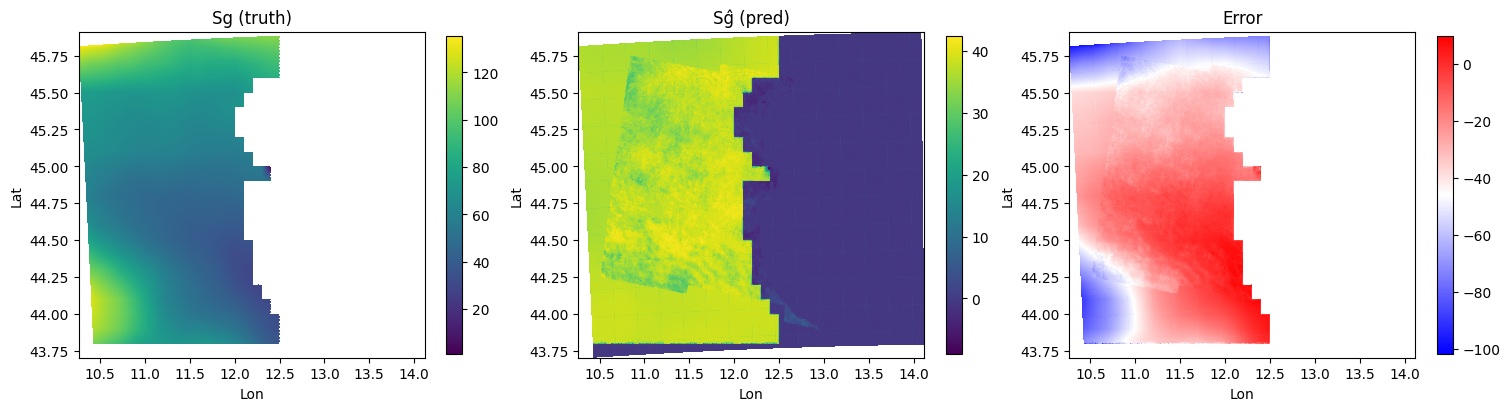

In [98]:
# Single figure with truth / pred / error side-by-side
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3, figsize=(15,4), constrained_layout=True)
for ax, da, title, cmap in [
    (axs[0], sg_true, "Sg (truth)", "viridis"),
    (axs[1], sg_hat,  "Sĝ (pred)", "viridis"),
    (axs[2], err,     "Error",      "bwr"),
]:
    if (lat is not None) and (lon is not None):
        im = ax.pcolormesh(lon.values, lat.values, da.values, shading="auto", cmap=cmap)
        ax.set_xlabel("Lon"); ax.set_ylabel("Lat")
    else:
        im = ax.imshow(da.values, cmap=cmap)
        ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title); fig.colorbar(im, ax=ax, fraction=0.046)
fig.savefig(OUT_FIG/f"tri_panel_{tid}.png", dpi=150); plt.show()


In [58]:
print(insar_m.shape, sg_on_insar.shape, sd_on_insar.shape, s0_on_insar.shape)
print(insar_m.time.equals(sg_on_insar.time),
      insar_m.y.equals(sg_on_insar.y),
      insar_m.x.equals(sg_on_insar.x))


(65, 2939, 3713) (65, 2939, 3713) (65, 2939, 3713) (65, 2939, 3713)
True True True


In [3]:
for da,name in [(insar_m,"InSAR"),(sg_on_insar,"Sg"),(sd_on_insar,"Sd"),(s0_on_insar,"S0")]:
    print(name, "NaN% =", float(da.isnull().mean().values)*100)


NameError: name 'insar_m' is not defined

In [28]:
print(pd.Index(insar_m.time.values).difference(sg_on_insar.time.values))


DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [29]:
i,j = insar_m.sizes['y']//2, insar_m.sizes['x']//2
print("center pixel:", float(insar_m.isel(y=i,x=j).std()), 
      float(sg_on_insar.isel(y=i,x=j).std()))


center pixel: 0.01842602901160717 nan


c:\Users\JR80FD\.conda\envs\datasci_env\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [30]:
lat,lon = float(insar_m.lat.isel(y=i,x=j)), float(insar_m.lon.isel(y=i,x=j))
print("lat/lon @center:", lat, lon)


lat/lon @center: 44.820499420166016 12.223923683166504


In [33]:
# If you ever did f = h5py.File(...), make sure it's closed
try:
    f.close()
except Exception:
    pass


Detach xarray object from any backing file - force data into RAM 

In [2]:
import h5py
import numpy as np
from pathlib import Path

# Detach from the source files by loading into memory
insar_m = insar_m.load()
sg_on_insar = sg_on_insar.load()
sd_on_insar = sd_on_insar.load()
s0_on_insar = s0_on_insar.load()


NameError: name 'insar_m' is not defined

Make sure target filenames are new (avoids any lock on existing files).
If you want fixed names, skip the timestamp; but for now use unique names to prove it works:

In [55]:
from pathlib import Path
import pandas as pd

BASE = Path(r"C:\Users\jr80fd\swin_test")
stamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
out_insar = BASE / f"insar_aligned_{stamp}.h5"
out_w3ra  = BASE / f"w3ra_aligned_{stamp}.h5"
print(out_insar, out_w3ra)


C:\Users\jr80fd\swin_test\insar_aligned_20250902_004412.h5 C:\Users\jr80fd\swin_test\w3ra_aligned_20250902_004412.h5


In [ ]:

# Now safely save
import h5py
import numpy as np
from pathlib import Path

out_insar = BASE / "insar_aligned.h5"
out_w3ra = BASE / "w3ra_aligned.h5"

# ---------------- save InSAR ----------------
with h5py.File(out_insar, "w") as f:
    f.create_dataset("InSAR", data=insar_m.values.astype(np.float32))
    f.create_dataset("time", data=insar_m.time.values.astype("S"))
    f.create_dataset("lat", data=insar_m.lat.values.astype(np.float32))
    f.create_dataset("lon", data=insar_m.lon.values.astype(np.float32))
print("Saved:", out_insar)

# ---------------- save W3RA ----------------
with h5py.File(out_w3ra, "w") as f:
    f.create_dataset("sg", data=sg_on_insar.values.astype(np.float32))
    f.create_dataset("sd", data=sd_on_insar.values.astype(np.float32))
    f.create_dataset("s0", data=s0_on_insar.values.astype(np.float32))
    f.create_dataset("time", data=sg_on_insar.time.values.astype("S"))
    f.create_dataset("lat", data=sg_on_insar.lat.values.astype(np.float32))
    f.create_dataset("lon", data=sg_on_insar.lon.values.astype(np.float32))
print("Saved:", out_w3ra)



In [41]:
INSAR_H5_ts = BASE / "insar_aligned.h5"   # from your save step
W3RA_H5_ts  = BASE / "w3ra_aligned.h5"    # contains Sg, Sd, S0


In [42]:



# ---- model/data config ----
WIN_T = 12             # months per training window (receptive field in time)
PATCH = (1, 128, 128)  # (t,h,w) patch fed to model; t must equal WIN_T for this script
STRIDE = (1, 128, 128) # sampling stride for patches
BATCH_SIZE = 2
NUM_EPOCHS = 5
LR = 2e-4
DEVICE = "cpu"   # "cuda" if torch.cuda.is_available() else "cpu"


In [43]:
import h5py, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
'''
USAGE: 
train_ds = InSAR2W3RA(INSAR_H5, W3RA_H5, win_t=WIN_T, patch_sz=PATCH, stride=STRIDE, split="train")
val_ds   = InSAR2W3RA(INSAR_H5, W3RA_H5, win_t=WIN_T, patch_sz=PATCH, stride=STRIDE, split="val")

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(val_ds)
'''

class InSAR2W3RA(Dataset):
    def __init__(self, insar_h5, w3ra_h5, win_t=12, patch_sz=(1,128,128), stride=(1,128,128),
                 split="train", val_frac=0.1, test_frac=0.1, zscore=True, seed=0):
        self.f_in = h5py.File(insar_h5, "r")
        self.f_w3 = h5py.File(w3ra_h5,  "r")
        self.D_in = self.f_in["InSAR"]        # (T,H,W)
        self.D0 = self.f_w3["S0"]             # (T,H,W)
        self.Dd = self.f_w3["Sd"]
        self.Dg = self.f_w3["Sg"]

        T,H,W = self.D_in.shape
        self.win_t = win_t
        self.pz = patch_sz
        self.stride = stride
        assert patch_sz[0] in (1, win_t), "Time patch must be 1 or WIN_T; use WIN_T here."
        assert win_t <= T

        # build list of (t0,y0,x0) windows
        t_idx = np.arange(0, T - win_t + 1, stride[0])
        y_idx = np.arange(0, H - patch_sz[1] + 1, stride[1])
        x_idx = np.arange(0, W - patch_sz[2] + 1, stride[2])
        idx = np.stack(np.meshgrid(t_idx, y_idx, x_idx, indexing="ij"), -1).reshape(-1,3)

        # split by time (keeps spatial leakage low)
        n_t = len(t_idx)
        n_val = max(1,int(n_t*val_frac))
        n_test= max(1,int(n_t*test_frac))
        rng = np.random.default_rng(seed)
        # choose complete time starts for val/test
        t_perm = rng.permutation(n_t)
        t_val  = set(t_idx[t_perm[:n_val]])
        t_test = set(t_idx[t_perm[n_val:n_val+n_test]])

        if split=="train":
            mask = np.array([t not in t_val and t not in t_test for t,_,_ in idx])
        elif split=="val":
            mask = np.array([t in t_val for t,_,_ in idx])
        else:
            mask = np.array([t in t_test for t,_,_ in idx])

        self.samples = idx[mask]

        # compute z-score statistics (approx: sample 200 patches)
        self.zscore = zscore
        if zscore:
            self.x_mean, self.x_std, self.y_mean, self.y_std = self._estimate_stats(rng, nsamp=200)
        else:
            self.x_mean = self.x_std = self.y_mean = self.y_std = None

    def _estimate_stats(self, rng, nsamp=200):
        xs, ys = [], []
        for _ in range(min(nsamp, len(self.samples))):
            t,y,x = self.samples[rng.integers(len(self.samples))]
            s = slice(t, t+self.win_t)
            yy = slice(y, y+self.pz[1]); xx = slice(x, x+self.pz[2])
            xin = self.D_in[s, yy, xx]       # (T,H,W)
            yout = np.stack([self.D0[s, yy, xx],
                             self.Dd[s, yy, xx],
                             self.Dg[s, yy, xx]], axis=0)   # (3,T,H,W)
            xs.append(np.nan_to_num(xin, nan=0.0))
            ys.append(np.nan_to_num(yout, nan=0.0))
        xcat = np.concatenate([u.reshape(-1,1) for u in xs],0)
        ycat = np.concatenate([u.reshape(-1,1) for u in ys],0)
        x_mean, x_std = float(np.mean(xcat)), float(np.std(xcat)+1e-6)
        y_mean, y_std = float(np.mean(ycat)), float(np.std(ycat)+1e-6)
        return x_mean, x_std, y_mean, y_std

    def __len__(self): return len(self.samples)

    def __getitem__(self, i):
        t,y,x = self.samples[i]
        s = slice(t, t+self.win_t)
        yy = slice(y, y+self.pz[1]); xx = slice(x, x+self.pz[2])

        xin  = self.D_in[s, yy, xx].astype(np.float32)         # (T,H,W)
        yout = np.stack([ self.D0[s,yy,xx], self.Dd[s,yy,xx], self.Dg[s,yy,xx] ],
                        axis=0).astype(np.float32)             # (3,T,H,W)

        # masks for NaN
        m = ~np.isnan(yout)                                    # (3,T,H,W)
        xin  = np.nan_to_num(xin,  nan=0.0)
        yout = np.nan_to_num(yout, nan=0.0)

        if self.zscore:
            xin  = (xin  - self.x_mean)/self.x_std
            yout = (yout - self.y_mean)/self.y_std

        x_t = torch.from_numpy(xin).unsqueeze(0)               # [1,T,H,W]
        y_t = torch.from_numpy(yout)                           # [3,T,H,W]
        m_t = torch.from_numpy(m.astype(np.float32))           # [3,T,H,W]
        return x_t, y_t, m_t


In [48]:
import xarray as xr
from pathlib import Path


p = BASE / "w3ra_aligned.nc"
try:
    ds = xr.open_dataset(p)
    print("\n---", name, "---")
    print("vars:", list(ds.data_vars)[:10])
    print("dims:", dict(ds.dims))
    if "time" in ds:
        print("time:", str(ds.time.values[:3]), "…", str(ds.time.values[-3:]), f"({ds.dims['time']} steps)")
    ds.close()
except Exception as e:
    print("\n---", name, "---\n", e)



--- S0 ---
vars: ['Sg', 'Sd', 'S0']
dims: {'lat': 22, 'lon': 24, 'time': 65}
time: ['2017-06-01T00:00:00.000000000' '2017-07-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000'] … ['2022-08-01T00:00:00.000000000' '2022-09-01T00:00:00.000000000'
 '2022-10-01T00:00:00.000000000'] (65 steps)


C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\2079874011.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("dims:", dict(ds.dims))
C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\2079874011.py:12: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("time:", str(ds.time.values[:3]), "…", str(ds.time.values[-3:]), f"({ds.dims['time']} steps)")


In [ ]:
from torch.utils.data import DataLoader


train_ds = InSAR2W3RA(INSAR_H5_ts, W3RA_H5_ts, win_t=WIN_T, patch_sz=PATCH, stride=STRIDE, split="train")
val_ds   = InSAR2W3RA(INSAR_H5_ts, W3RA_H5_ts, win_t=WIN_T, patch_sz=PATCH, stride=STRIDE, split="val")


train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,
                      shuffle=True, num_workers=0,  # <-- important
                      pin_memory=False, persistent_workers=False)

val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE,
                      shuffle=False, num_workers=0, # <-- important
                      pin_memory=False, persistent_workers=False)



len(train_ds), len(val_ds)

In [46]:
import torch.nn as nn
import torch.nn.functional as F

def window_partition_3d(x, win):  # x: [B,T,H,W,C]
    WT,WH,WW = win
    B,T,H,W,C = x.shape
    assert T%WT==0 and H%WH==0 and W%WW==0
    x = x.view(B, T//WT, WT, H//WH, WH, W//WW, WW, C)
    x = x.permute(0,1,3,5,2,4,6,7).contiguous()               # [B, nWT, nWH, nWW, WT, WH, WW, C]
    return x.view(-1, WT*WH*WW, C)                            # [B*nWins, tokens, C]

def window_unpartition_3d(windows, win, B, T, H, W, C):
    WT,WH,WW = win
    nWT, nWH, nWW = T//WT, H//WH, W//WW
    x = windows.view(B, nWT, nWH, nWW, WT, WH, WW, C)
    x = x.permute(0,1,4,2,5,3,6,7).contiguous()
    return x.view(B, T, H, W, C)

class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim*mlp_ratio)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(dim*mlp_ratio, dim)
    def forward(self, x): return self.fc2(self.act(self.fc1(x)))

class SwinBlock3D(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=(2,4,4), shift=False):
        super().__init__()
        self.dim = dim
        self.win = window_size
        self.shift = shift
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim)

    def forward(self, x):               # x: [B,T,H,W,C]
        B,T,H,W,C = x.shape
        if self.shift:
            sT,sH,sW = self.win[0]//2, self.win[1]//2, self.win[2]//2
            x = torch.roll(x, shifts=(-sT,-sH,-sW), dims=(1,2,3))
        # partition → attn per window
        xw = window_partition_3d(x, self.win)               # [B*nWins, tokens, C]
        xw = self.norm1(xw)
        attn_out,_ = self.attn(xw, xw, xw)                  # window MSA
        xw = xw + attn_out
        xw = xw + self.mlp(self.norm2(xw))
        # unpartition
        x = window_unpartition_3d(xw, self.win, B,T,H,W,C)
        if self.shift:
            sT,sH,sW = self.win[0]//2, self.win[1]//2, self.win[2]//2
            x = torch.roll(x, shifts=(+sT,+sH,+sW), dims=(1,2,3))
        return x

class PatchEmbed3D(nn.Module):
    def __init__(self, in_ch=1, embed_dim=96, patch_size=(1,4,4)):
        super().__init__()
        self.proj = nn.Conv3d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):               # [B,1,T,H,W]
        x = self.proj(x)                # [B,C,T',H',W']
        x = x.permute(0,2,3,4,1)        # → [B,T',H',W',C]
        return x

class PatchMerge3D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.reduction = nn.Linear(dim*4, dim*2)
    def forward(self, x):               # [B,T,H,W,C]
        B,T,H,W,C = x.shape
        x = x.view(B,T, H//2,2, W//2,2, C).permute(0,1,2,4,3,5,6).contiguous()
        x = x.view(B,T, H//2, W//2, 4*C)
        return self.reduction(x)

class PatchExpand3D(nn.Module):
    def __init__(self, dim_out):
        super().__init__()
        self.dim_out = dim_out
    def forward(self, x):               # [B,T,H,W,Cin] → upsample H,W x2, reduce channels
        B,T,H,W,C = x.shape
        x = x.permute(0,4,1,2,3)        # [B,C,T,H,W]
        x = F.interpolate(x, scale_factor=(1,2,2), mode="trilinear", align_corners=False)
        x = nn.Conv3d(C, self.dim_out, kernel_size=1)(x)
        return x.permute(0,2,3,4,1)     # [B,T,H',W',Cout]

class SwinUNet3D(nn.Module):
    def __init__(self, in_ch=1, out_ch=3, embed_dim=96,
                 depths=(2,2,2), num_heads=(3,3,3),
                 window_size=(2,4,4), patch_size=(1,4,4)):
        super().__init__()
        self.patch_embed = PatchEmbed3D(in_ch, embed_dim, patch_size)
        C = embed_dim

        # encoder stages
        self.enc1 = nn.ModuleList([SwinBlock3D(C,   num_heads[0], window_size, shift=(i%2==1)) for i in range(depths[0])])
        self.pm1  = PatchMerge3D(C);   C *= 2
        self.enc2 = nn.ModuleList([SwinBlock3D(C,   num_heads[1], window_size, shift=(i%2==1)) for i in range(depths[1])])
        self.pm2  = PatchMerge3D(C);   C *= 2
        self.enc3 = nn.ModuleList([SwinBlock3D(C,   num_heads[2], window_size, shift=(i%2==1)) for i in range(depths[2])])

        # decoder
        self.up2  = PatchExpand3D(C//2) # to match skip2
        self.dec2 = nn.ModuleList([SwinBlock3D(C,   num_heads[1], window_size, shift=(i%2==1)) for i in range(1)])
        self.up1  = PatchExpand3D(C//4) # to match skip1
        self.dec1 = nn.ModuleList([SwinBlock3D(C//2,num_heads[0], window_size, shift=(i%2==1)) for i in range(1)])

        self.head = nn.Sequential(
            nn.LayerNorm(C//2),
            nn.Linear(C//2, out_ch)
        )

    def forward(self, x):               # x: [B,1,T,H,W]
        B = x.size(0)
        z = self.patch_embed(x)         # [B,T',H',W',C]
        # enc1
        for blk in self.enc1: z = blk(z)
        skip1 = z
        z = self.pm1(z)                 # down x2 (H,W), Cx2
        # enc2
        for blk in self.enc2: z = blk(z)
        skip2 = z
        z = self.pm2(z)                 # down x2 again
        # enc3 (bottleneck)
        for blk in self.enc3: z = blk(z)
        # up2
        z = self.up2(z)                 # up x2
        z = torch.cat([z, skip2], dim=-1)
        for blk in self.dec2: z = blk(z)
        # up1
        z = self.up1(z)                 # up x2
        z = torch.cat([z, skip1], dim=-1)
        for blk in self.dec1: z = blk(z)
        # head linear per-token → channels
        B,T,H,W,C = z.shape
        z = self.head(z).view(B,T,H,W,-1).permute(0,4,1,2,3)  # [B,out_ch,T,H,W]
        return z


In [47]:
class MaskedMAE(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pred, tgt, mask):
        # pred,tgt: [B,3,T,H,W]; mask: [B,3,T,H,W] (1=valid)
        valid = mask>0.5
        diff = torch.abs(pred - tgt)
        diff = diff[valid]
        return diff.mean() if diff.numel() else (pred-tgt).abs().mean()


In [51]:
import torch

DEVICE = "cpu"   # force CPU
print("Using", DEVICE)


Using cpu


In [ ]:
model = SwinUNet3D(in_ch=1, out_ch=3, embed_dim=64,
                   depths=(2,2,2), num_heads=(2,4,4),
                   window_size=(2,4,4), patch_size=(1,4,4)).to(DEVICE)

opt  = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
loss_fn = MaskedMAE()

def step(dl, train=True):
    model.train(train)
    tot, n = 0.0, 0
    for x,y,m in dl:
        x = x.to(DEVICE)                 # [B,1,T,H,W]
        y = y.to(DEVICE)                 # [B,3,T,H,W]
        m = m.to(DEVICE)                 # [B,3,T,H,W]
        if train: opt.zero_grad()
        yhat = model(x)
        loss = loss_fn(yhat, y, m)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        tot += float(loss.detach().cpu())
        n += 1
    return tot/max(1,n)

for epoch in range(1, NUM_EPOCHS+1):
    tr = step(train_dl, True)
    va = step(val_dl,   False)
    print(f"Epoch {epoch:02d} | train {tr:.4f} | val {va:.4f}")


# 6) Build model tensors [B, C, T, H, W]

Input 
X: InSAR → [B, 1, T, H, W]

Output 
Y: stack W3RA layers → [B, 3, T, H, W]

We’ll also normalize (z-score) and keep the stats for de-normalization later.

In [ ]:
# stack W3RA channels in the order [Sg, Sd, S0]
w3ra_stack = xr.concat([sg_r, sd_r, s0_r], dim="channel").assign_coords(channel=["Sg","Sd","S0"])
print("W3RA stack:", w3ra_stack.shape, w3ra_stack.coords["channel"].values)

# Ensure matching dims order: (time, y, x)
insar_m = insar_m.transpose("time","y","x")
w3ra_stack = w3ra_stack.transpose("time","y","x")

T, H, W = insar_m.shape
C_out = 3

# to numpy
x_np = insar_m.values.astype(np.float32)                     # (T,H,W)
y_np = w3ra_stack.values.astype(np.float32)                  # (C_out,T,H,W)

# add batch and channel dimensions → [B, C, T, H, W]
x_t = torch.from_numpy(x_np).unsqueeze(0).unsqueeze(1)       # [1,1,T,H,W]
y_t = torch.from_numpy(y_np).unsqueeze(0)                    # [1,C_out,T,H,W]

print("X tensor:", x_t.shape, " Y tensor:", y_t.shape)

# ---- Normalization ----
# InSAR: single channel
x_mean = x_t.mean(); x_std = x_t.std().clamp_min(1e-6)
x_norm = (x_t - x_mean) / x_std

# W3RA per-channel stats
y_mean = y_t.mean(dim=(0,2,3,4), keepdim=True)
y_std  = y_t.std(dim=(0,2,3,4), keepdim=True).clamp_min(1e-6)
y_norm = (y_t - y_mean) / y_std

norm_stats = {"x_mean": float(x_mean), "x_std": float(x_std),
              "y_mean": y_mean.squeeze().tolist(), "y_std": y_std.squeeze().tolist()}
norm_stats


# 7) Minimal model (the “modified” Swin-lite U-Net)

Paste this once if you don’t already have it in the notebook.

In [ ]:
class SimpleSwinBlock3D(nn.Module):
    def __init__(self, dim, num_heads=4, mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        hidden = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(nn.Linear(dim, hidden), nn.GELU(), nn.Linear(hidden, dim))

    def forward(self, x):  # [B,C,T,H,W]
        B, C, T, H, W = x.shape
        y = x.permute(0,2,3,4,1).contiguous().view(B, T*H*W, C)
        z = self.norm1(y)
        out,_ = self.attn(z,z,z)
        y = y + out
        y = y + self.mlp(self.norm2(y))
        return y.view(B,T,H,W,C).permute(0,4,1,2,3).contiguous()

class PatchEmbed3D(nn.Module):
    def __init__(self, in_ch=1, embed_dim=64, patch_size=(1,4,4)):
        super().__init__()
        self.proj = nn.Conv3d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.bn = nn.BatchNorm3d(embed_dim)
    def forward(self, x):
        return self.bn(self.proj(x))

class Swin3DNetMini(nn.Module):
    def __init__(self, in_ch=1, out_ch=3, embed_dim=64):
        super().__init__()
        self.patch = PatchEmbed3D(in_ch, embed_dim, patch_size=(1,4,4))
        self.enc1  = SimpleSwinBlock3D(embed_dim, num_heads=4)
        self.down  = nn.Conv3d(embed_dim, embed_dim*2, kernel_size=(1,2,2), stride=(1,2,2))
        self.enc2  = SimpleSwinBlock3D(embed_dim*2, num_heads=8)
        self.up    = nn.ConvTranspose3d(embed_dim*2, embed_dim, kernel_size=(1,2,2), stride=(1,2,2))
        self.fuse  = nn.Conv3d(embed_dim*2, embed_dim, kernel_size=1)
        self.head  = nn.Conv3d(embed_dim, out_ch, kernel_size=1)

    def forward(self, x):  # [B,1,T,H,W]
        B,_,T,H,W = x.shape
        z0 = self.patch(x)           # [B,D,T,H/4,W/4]
        e1 = self.enc1(z0)
        e2i= self.down(e1)           # [B,2D,T,H/8,W/8]
        e2 = self.enc2(e2i)
        up = self.up(e2)             # [B,D,T,H/4,W/4]
        cat= torch.cat([up, e1], dim=1)
        fz = self.fuse(cat)
        y  = self.head(fz)           # [B,out_ch,T,H/4,W/4]
        # back to original size
        y  = F.interpolate(y, size=(T,H,W), mode="trilinear", align_corners=False)
        return y


# 8) Train for a few epochs (sanity)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Swin3DNetMini(in_ch=1, out_ch=3, embed_dim=64).to(device)

x_batch = x_norm.to(device)  # [1,1,T,H,W]
y_batch = y_norm.to(device)  # [1,3,T,H,W]

criterion = nn.L1Loss()  # MAE (you can switch to MSE)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)

loss_history = []
model.train()
for epoch in range(10):   # start small to test pipeline
    optimizer.zero_grad()
    y_pred = model(x_batch)
    loss = criterion(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    print(f"epoch {epoch+1:02d} | loss {loss.item():.5f}")


In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history); plt.xlabel("epoch"); plt.ylabel("train loss"); plt.show()


# 9) De-normalize and inspect one pixel time series + lag

In [ ]:
model.eval()
with torch.no_grad():
    y_hat = model(x_batch).cpu()    # [1,3,T,H,W]

# de-normalize
y_hat_dn = y_hat * y_std + y_mean   # back to original units

# center pixel
_, C, T, H, W = y_hat.shape
i, j = H//2, W//2
names = ["Sg","Sd","S0"]

def best_lag(yt, yp, max_lag=6):
    lags = np.arange(-max_lag, max_lag+1)
    corrs = []
    for L in lags:
        if L>0: a,b = yt[L:], yp[:-L]
        elif L<0: a,b = yt[:L], yp[-L:]
        else: a,b = yt, yp
        if len(a)>=2 and len(b)>=2:
            corrs.append(np.corrcoef(a,b)[0,1])
        else:
            corrs.append(np.nan)
    k = int(np.nanargmax(corrs))
    return int(lags[k]), float(corrs[k])

for c,name in enumerate(names):
    yt = (y_t[0,c,:,i,j]*y_std[0,c,0,0,0] + y_mean[0,c,0,0,0]).cpu().numpy()
    yp = y_hat_dn[0,c,:,i,j].numpy()
    L, R = best_lag(yt, yp, max_lag=6)
    print(f"{name}: best lag={L} steps, corr={R:.3f}")
    plt.figure(); plt.plot(yt,label="true"); plt.plot(yp,label="pred")
    plt.title(f"{name} @ center pixel (lag {L}, corr {R:.2f})"); plt.legend(); plt.show()


In [4]:
import xarray as xr
ds = xr.open_dataset(r"C:\Users\jr80fd\swin_test\w3ra\Sg_EU.nc")  # works once netCDF4 is present


In [ ]:
import xarray as xr
from pathlib import Path

nc_paths = [
    Path(r"C:\Users\jr80fd\swin_test\w3ra\W3RA_Sg_EU.nc"),
    Path(r"C:\Users\jr80fd\swin_test\w3ra\W3RA_Sd_EU.nc"),
    Path(r"C:\Users\jr80fd\swin_test\w3ra\S0_EU.nc"),
]

for p in nc_paths:
    ds = xr.open_dataset(p)
    print("\n", p.name)
    print(ds)            # prints dims/coords/vars
    print("vars:", list(ds.data_vars))
    for v in ds.data_vars:
        print(v, ds[v].dims, ds[v].shape, ds[v].attrs)
    ds.close()
